Diabetes

# Hiểu biết nghiệp vụ (Business Understanding)

**1.1. Bối cảnh & Dữ liệu**

Bệnh **tiểu đường** là gánh nặng sức khỏe lớn tại Mỹ (34,2 triệu mắc, 88 triệu tiền tiểu đường - CDC 2018). **Phát hiện sớm** qua sàng lọc là rất quan trọng.
Dữ liệu sử dụng: **BRFSS 2015** (CDC) với hơn **250.000 mẫu** và **22 đặc trưng** về hành vi, nhân khẩu học, và sức khỏe.

**1.2. Vấn đề Nghiệp vụ**
Xét nghiệm y khoa diện rộng không khả thi. Cần xây dựng một **mô hình dự đoán nguy cơ tiểu đường** dựa trên dữ liệu khảo sát để:
* **Sàng lọc sớm** và xác định người có nguy cơ cao.
* Xác định **yếu tố nguy cơ** chính.
* Hỗ trợ **quyết định y tế cộng đồng**.

**1.3. Mục tiêu Dự án**
1.  Thực hiện **EDA** để hiểu dữ liệu và mối quan hệ giữa các yếu tố.
2.  **Kiểm định giả thuyết** để tìm các yếu tố ảnh hưởng có ý nghĩa thống kê.
3.  **Xây dựng mô hình** dự đoán nguy cơ tiểu đường.
4.  Xử lý vấn đề **mất cân bằng lớp** (bằng resampling hoặc `class_weight`).
5.  **Đánh giá mô hình** toàn diện (ROC-AUC, Recall, Precision, F1).

**1.4. Câu hỏi Nghiên cứu Trọng tâm**
* **Yếu tố dự báo tốt nhất** là gì?
* Mức độ ảnh hưởng cụ thể của **BMI, huyết áp, thu nhập, hoạt động thể chất**?
* Có thể **rút gọn bộ câu hỏi** mà vẫn giữ được độ chính xác không?
* **Kỹ thuật cân bằng lớp** nào (resampling/`class_weight`) hiệu quả nhất?

**1.5. Kết quả Mong đợi**
* **Hiểu rõ** dữ liệu và các yếu tố nguy cơ chính.
* **Mô hình dự đoán hiệu suất cao** ($\text{ROC-AUC}$, $\text{Recall}$ tốt).
* Đề xuất **form câu hỏi rút gọn** để áp dụng thực tế.

# Hiểu dữ liệu (Data Understanding)

## Import và mô tả dữ liệu

### Import các thư viện

In [55]:
# =========================
# 1) Thư viện cơ bản
# =========================
import numpy as np
import pandas as pd

# =========================
# 2) Trực quan hóa
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 3) Thống kê & kiểm định
# =========================
from scipy import stats
from scipy.stats import chi2_contingency

# =========================
# 4) Tiền xử lý & chọn đặc trưng (scikit-learn)
# =========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

# =========================
# 5) Đánh giá mô hình
# =========================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

# =========================
# 6) Các mô hình học máy
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# =========================
# 7) Xử lý mất cân bằng dữ liệu & pipeline
# =========================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks

### Tải và xem cấu trúc dữ liệu (info(), head())

In [2]:
Data_PATH="../data/raw/diabetes_binary_health_indicators_BRFSS2015.csv"

In [3]:
df = pd.read_csv(Data_PATH)

pd.set_option('display.max_columns', None)

print(df.shape)
df.head()

(253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

### Giải thích ý nghĩa các cột trong DataFrame

| Cột                  | Giải thích                                                                 | Giá trị                                                                 |
| :------------------- | :------------------------------------------------------------------------- | :---------------------------------------------------------------------- |
| `Diabetes_binary`    | Chỉ báo nhị phân cho bệnh tiểu đường                                        | 0: không tiểu đường, 1: tiền tiểu đường hoặc tiểu đường (biến mục tiêu)   |
| `HighBP`             | Huyết áp cao                                                               | 0: không, 1: có                                                         |
| `HighChol`           | Cholesterol cao                                                            | 0: không, 1: có                                                         |
| `CholCheck`          | Kiểm tra cholesterol trong 5 năm qua                                      | 0: không, 1: có                                                         |
| `BMI`                | Chỉ số khối cơ thể (Body Mass Index)                                       | Giá trị số                                                              |
| `Smoker`             | Hút thuốc                                                                 | 0: không, 1: có                                                         |
| `Stroke`             | Có tiền sử đột quỵ                                                         | 0: không, 1: có                                                         |
| `HeartDiseaseorAttack` | Có tiền sử bệnh tim mạch vành hoặc đau tim                               | 0: không, 1: có                                                         |
| `PhysActivity`       | Hoạt động thể chất trong 30 ngày qua (không bao gồm công việc)            | 0: không, 1: có                                                         |
| `Fruits`             | Tiêu thụ trái cây 1 lần trở lên mỗi ngày                                  | 0: không, 1: có                                                         |
| `Veggies`            | Tiêu thụ rau củ 1 lần trở lên mỗi ngày                                    | 0: không, 1: có                                                         |
| `HvyAlcoholConsump`  | Uống nhiều rượu (nam giới >= 14 ly/tuần, nữ giới >= 7 ly/tuần)           | 0: không, 1: có                                                         |
| `AnyHealthcare`      | Có bảo hiểm y tế                                                          | 0: không, 1: có                                                         |
| `NoDocbcCost`        | Cần gặp bác sĩ nhưng không thể vì chi phí                                  | 0: không, 1: có                                                         |
| `GenHlth`            | Sức khỏe chung                                                             | 1: xuất sắc, 2: rất tốt, 3: tốt, 4: khá, 5: kém                          |
| `MentHlth`           | Số ngày sức khỏe tinh thần không tốt trong 30 ngày qua                     | 0-30 ngày                                                               |
| `PhysHlth`           | Số ngày sức khỏe thể chất không tốt trong 30 ngày qua                      | 0-30 ngày                                                               |
| `DiffWalk`           | Khó khăn khi đi lại hoặc leo cầu thang                                     | 0: không, 1: có                                                         |
| `Sex`                | Giới tính                                                                  | 0: nữ, 1: nam                                                           |
| `Age`                | Thang đo tuổi 13 cấp                                                       | 1: 18-24, ..., 13: >= 80                                                |
| `Education`          | Thang đo giáo dục 6 cấp                                                    | 1: chưa học cấp 1, ..., 6: tốt nghiệp đại học                          |
| `Income`             | Thang đo thu nhập hàng năm 8 cấp                                          | 1: < 10k USD, ..., 8: >= 75k USD                                        |

## Khám phá dữ liệu (Exploration)

### Kiểm tra giá trị thiếu và dữ liệu trùng lặp

In [5]:
missing_values = df.isnull().sum()

# Tính tỷ lệ phần trăm giá trị thiếu
missing_percent = (missing_values / len(df)) * 100

# Gộp vào một bảng tóm tắt
missing_summary = pd.DataFrame({
    'Số lượng giá trị thiếu': missing_values,
    'Tỷ lệ (%)': missing_percent.round(3)
}).sort_values(by='Số lượng giá trị thiếu', ascending=False)

print("🔍 Thống kê giá trị thiếu trong tập dữ liệu:")
display(missing_summary)

🔍 Thống kê giá trị thiếu trong tập dữ liệu:


,Số lượng giá trị thiếu,Tỷ lệ (%)
Diabetes_binary,0,0.0
HighBP,0,0.0
Education,0,0.0
Age,0,0.0
Sex,0,0.0
DiffWalk,0,0.0
PhysHlth,0,0.0
MentHlth,0,0.0
GenHlth,0,0.0
NoDocbcCost,0,0.0


In [6]:
duplicates = df[df.duplicated()]
print("Duplicate Rows : ",len(duplicates))
duplicates.head()

Duplicate Rows :  24206


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1242,1.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0


### Kiểm tra số lượng giá trị duy nhất

In [7]:
unique_values_optimized = df.nunique().to_frame(name='Số lượng giá trị duy nhất')
display(unique_values_optimized)

,Số lượng giá trị duy nhất
Diabetes_binary,2
HighBP,2
HighChol,2
CholCheck,2
BMI,84
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


In [8]:
def v_counts(dataframe):
    for i in dataframe :
        print(dataframe[i].value_counts())
        print("_____________________________________________________________________________")

v_counts(df)

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64
_____________________________________________________________________________
HighBP
0.0    144851
1.0    108829
Name: count, dtype: int64
_____________________________________________________________________________
HighChol
0.0    146089
1.0    107591
Name: count, dtype: int64
_____________________________________________________________________________
CholCheck
1.0    244210
0.0      9470
Name: count, dtype: int64
_____________________________________________________________________________
BMI
27.0    24606
26.0    20562
24.0    19550
25.0    17146
28.0    16545
        ...  
85.0        1
91.0        1
86.0        1
90.0        1
78.0        1
Name: count, Length: 84, dtype: int64
_____________________________________________________________________________
Smoker
0.0    141257
1.0    112423
Name: count, dtype: int64
_____________________________________________________________________________
Stroke
0.0    243

### Thống kê mô tả tổng quát

In [9]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


*   **Không có giá trị thiếu:** Dữ liệu đầy đủ, không cần xử lý missing values.
*   **Mất cân bằng lớp:** Biến mục tiêu `Diabetes_binary` có sự mất cân bằng lớn (khoảng 13.9% mắc tiểu đường). Cần xử lý khi xây dựng mô hình.
*   **Phân bố biến:**
    *   Các biến nhị phân/phân loại: Tỷ lệ phân bố đa dạng. `CholCheck` và `AnyHealthcare` có tỷ lệ "Có" rất cao. `Stroke`, `HeartDiseaseorAttack`, `HvyAlcoholConsump` có tỷ lệ "Có" thấp.
    *   Các biến số/đếm (`BMI`, `MentHlth`, `PhysHlth`): Có phạm vi giá trị rộng, giá trị max cao cho thấy khả năng có ngoại lai. Cần kiểm tra kỹ hơn phân bố của các biến này.
    *   Các biến thang đo thứ bậc (`GenHlth`, `Age`, `Education`, `Income`): Phân bố nghiêng về các nhóm sức khỏe tốt hơn, tuổi cao hơn, trình độ giáo dục và thu nhập cao hơn.

Những nhận xét này là cơ sở để tiền xử lý dữ liệu và lựa chọn mô hình phù hợp.

## Phân tích dữ liệu khám phá (EDA)

### Phân bố biến mục tiêu Diabetes_binary

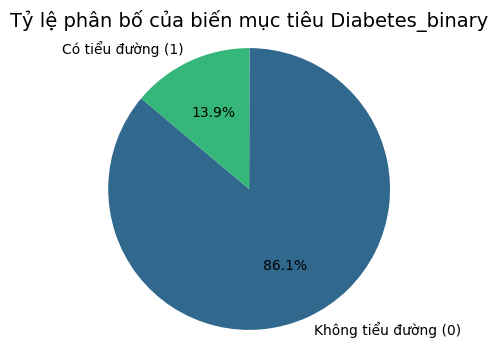

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

In [10]:
diabetes_counts = df['Diabetes_binary'].value_counts()

plt.figure(figsize=(4, 4))

colors = sns.color_palette('viridis', len(diabetes_counts))
plt.pie(diabetes_counts, labels=['Không tiểu đường (0)', 'Có tiểu đường (1)'], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Tỷ lệ phân bố của biến mục tiêu Diabetes_binary', fontsize=14)
plt.axis('equal')  
plt.show()

display(diabetes_counts)

Biểu đồ tròn cho thấy rõ ràng sự mất cân bằng đáng kể trong biến mục tiêu `Diabetes_binary`. Tỷ lệ người mắc hoặc tiền tiểu đường (lớp 1) chiếm khoảng **13.9%** tổng số mẫu, trong khi tỷ lệ người không mắc tiểu đường (lớp 0) chiếm tới **86.1%**. Sự mất cân bằng lớp này là một vấn đề quan trọng cần được xem xét và xử lý trong các giai đoạn sau của dự án (như tiền xử lý dữ liệu và xây dựng mô hình) để tránh làm giảm hiệu suất dự đoán của mô hình đối với lớp thiểu số (người mắc/tiền tiểu đường).

### Phân bố các biến liên tục (BMI, MentHlth, PhysHlth)

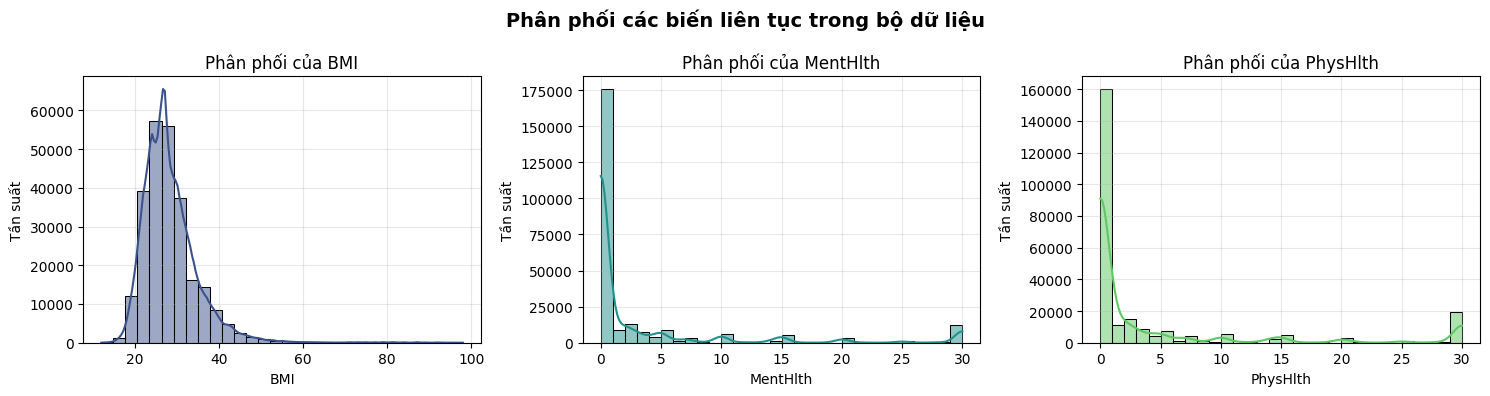

In [11]:
# Xác định các biến liên tục
continuous_cols = ['BMI', 'MentHlth', 'PhysHlth']

# Lấy bảng màu viridis
colors = sns.color_palette('viridis', len(continuous_cols))

# Tạo figure với lưới 1 hàng x 3 cột
fig, axes = plt.subplots(1, len(continuous_cols), figsize=(15, 4))

# Lặp qua từng biến và plot
for i, col in enumerate(continuous_cols):
    sns.histplot(
        data=df, x=col, bins=30, kde=True,
        color=colors[i], ax=axes[i]
    )
    axes[i].set_title(f"Phân phối của {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Tần suất")
    axes[i].grid(alpha=0.3)

plt.suptitle("Phân phối các biến liên tục trong bộ dữ liệu", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

-	BMI có phân phối lệch phải nhẹ (right-skewed), tập trung chủ yếu trong khoảng [20–35], cho thấy đa phần người tham gia có chỉ số khối cơ thể bình thường đến hơi thừa cân.
-	MentHlth (số ngày sức khỏe tinh thần không tốt) và PhysHlth (số ngày sức khỏe thể chất không tốt) đều có phân phối lệch mạnh về 0, nghĩa là phần lớn người khảo sát ít gặp vấn đề sức khỏe trong 30 ngày qua.
-	Tuy nhiên, vẫn có một số đỉnh nhỏ ở giá trị 30, thể hiện nhóm người có vấn đề sức khỏe kéo dài cả tháng, đáng chú ý trong các phân tích sâu hơn về bệnh tiểu đường.
	
-> Nhìn chung, dữ liệu cho thấy phần lớn người khảo sát có sức khỏe ổn định, nhưng một nhóm nhỏ có chỉ số BMI cao và sức khỏe kém có thể là nhóm có nguy cơ tiểu đường cao hơn.

### Phân bố giới tính (Sex)

In [12]:
# Tổng số nam/nữ
total_by_sex = df['Sex'].value_counts().sort_index()

# Số người mắc tiểu đường theo giới tính
diabetes_by_sex = df[df['Diabetes_binary'] == 1]['Sex'].value_counts().sort_index()

# Tính tỷ lệ mắc bệnh (%)
rate_by_sex = (diabetes_by_sex / total_by_sex * 100).round(2)

# Tạo bảng tổng hợp
summary = pd.DataFrame({
    'Giới tính': ['Nữ', 'Nam'],
    'Tổng số người': total_by_sex.values,
    'Số người mắc tiểu đường': diabetes_by_sex.values,
    'Tỷ lệ mắc tiểu đường (%)': rate_by_sex.values
})

display(summary)

,Giới tính,Tổng số người,Số người mắc tiểu đường,Tỷ lệ mắc tiểu đường (%)
0,Nữ,141974,18411,12.97
1,Nam,111706,16935,15.16


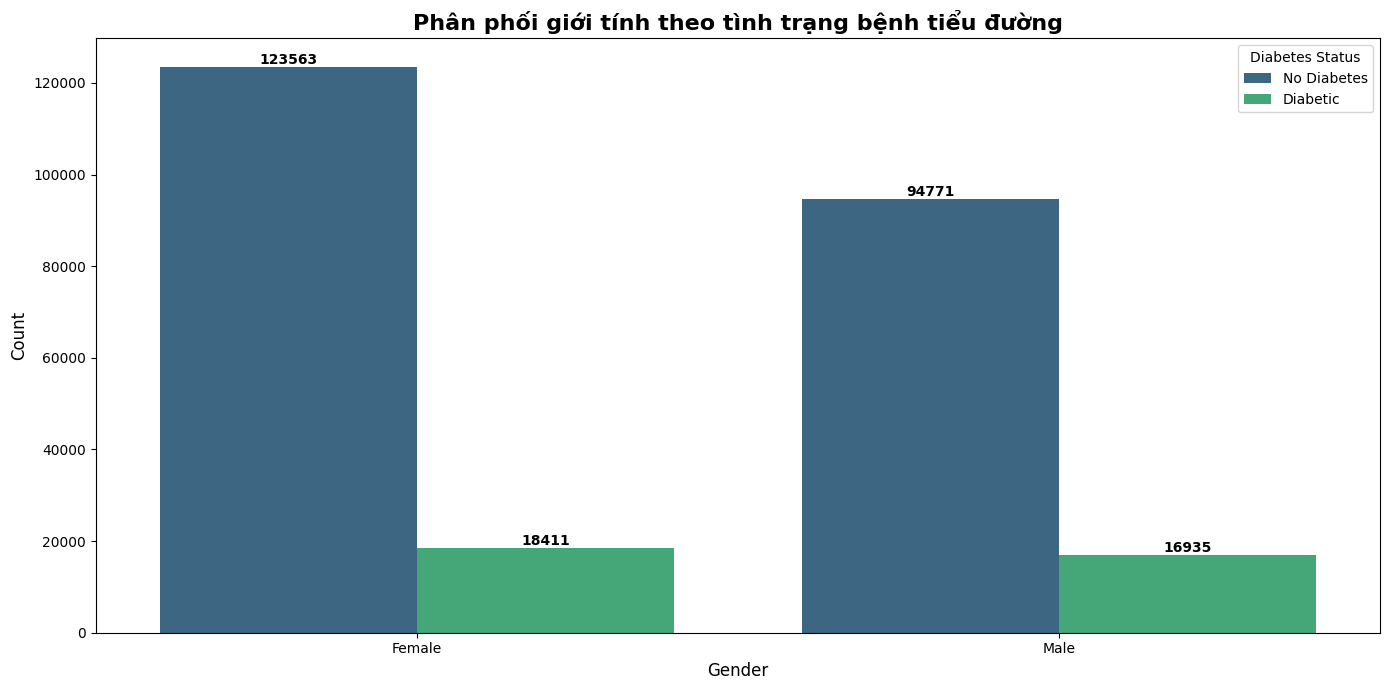

In [13]:
df_gender = df[['Sex', 'Diabetes_binary']].copy()

# Ánh xạ nhãn hiển thị
gender_map = {0: 'Female', 1: 'Male'}
diabetes_map = {0: 'No Diabetes', 1: 'Diabetic'}

df_gender['Sex'] = df_gender['Sex'].map(gender_map)
df_gender['Diabetes_binary'] = df_gender['Diabetes_binary'].map(diabetes_map)

# --- Biểu đồ gộp ---
plt.figure(figsize=(14,7))
palette = sns.color_palette('viridis', 2)

sns.countplot(
    data=df_gender,
    x='Sex',
    hue='Diabetes_binary',
    palette=palette
)

plt.title('Phân phối giới tính theo tình trạng bệnh tiểu đường', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Diabetes Status', loc='upper right')

# Thêm nhãn số lượng lên đầu cột
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Tổng quan tập dữ liệu: Biểu đồ cho thấy trong toàn bộ tập dữ liệu, số lượng nữ giới (141,974) nhiều hơn nam giới (111,706).

Phân bố theo Tình trạng Tiểu đường: Khi xem xét riêng từng nhóm:

- Trong nhóm không mắc tiểu đường, số lượng nữ giới (123,563) vẫn cao hơn nam giới (94,771).
- Tuy nhiên, trong nhóm mắc/tiền tiểu đường, số lượng nam giới (16,935) lại gần bằng hoặc thậm chí hơi cao hơn nữ giới (18,411).
  
-> Điều này chỉ ra rằng, mặc dù số lượng nữ giới trong tập dữ liệu lớn hơn, tỷ lệ nam giới mắc hoặc tiền tiểu đường có vẻ cao hơn so với nữ giới.

### Phân bố theo nhóm tuổi (Age)

In [14]:
age_labels = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39',
    5: '40-44', 6: '45-49', 7: '50-54', 8: '55-59',
    9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'
}

summary = (
    df.groupby('Age')['Diabetes_binary']
    .agg(['count', 'sum', 'mean'])
    .reset_index()
    .rename(columns={
        'count': 'Tổng số người',
        'sum': 'Số người mắc',
        'mean': 'Tỷ lệ mắc bệnh'
    })
)

summary['Nhóm tuổi'] = summary['Age'].map(age_labels)
summary['Tỷ lệ mắc bệnh (%)'] = (summary['Tỷ lệ mắc bệnh'] * 100).round(2)

# Chỉ chọn các cột cần dùng
summary = summary[['Nhóm tuổi', 'Tổng số người', 'Số người mắc', 'Tỷ lệ mắc bệnh (%)']]

display(
    summary.style
    .bar(subset=['Tỷ lệ mắc bệnh (%)'], color='#6baed6', 
         vmin=0, vmax=summary['Tỷ lệ mắc bệnh (%)'].max())
    .format({
        'Tổng số người': '{:,}',
        'Số người mắc': '{:,}',
        'Tỷ lệ mắc bệnh (%)': '{:.2f}'
    })
)


,Nhóm tuổi,Tổng số người,Số người mắc,Tỷ lệ mắc bệnh (%)
0,18-24,"5,700",78.0,1.37
1,25-29,"7,598",140.0,1.84
2,30-34,"11,123",314.0,2.82
3,35-39,"13,823",626.0,4.53
4,40-44,"16,157","1,051.0",6.50
5,45-49,"19,819","1,742.0",8.79
6,50-54,"26,314","3,088.0",11.74
7,55-59,"30,832","4,263.0",13.83
8,60-64,"33,244","5,733.0",17.25
9,65-69,"32,194","6,558.0",20.37


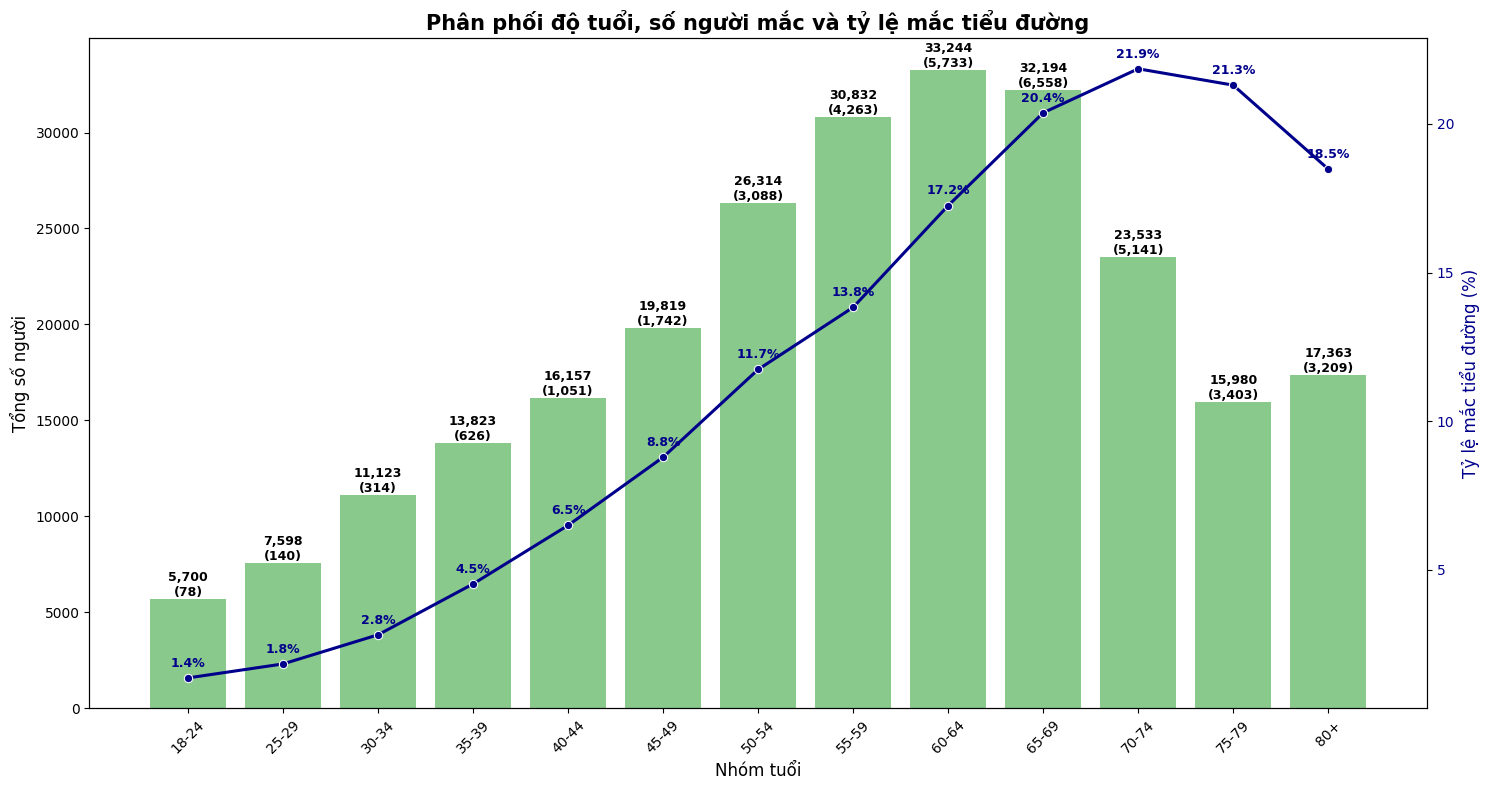

In [15]:
fig, ax1 = plt.subplots(figsize=(15,8))
palette = sns.color_palette('viridis', 11)

# Barplot
sns.barplot(
    data=summary,
    x='Nhóm tuổi',
    y='Tổng số người',
    color=palette[8],
    alpha=0.8,
    ax=ax1
)
ax1.set_xlabel('Nhóm tuổi', fontsize=12)
ax1.set_ylabel('Tổng số người', fontsize=12, color='black')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor='black')

# Ghi chú tổng số & số mắc
for i, p in enumerate(ax1.patches):
    total = int(p.get_height())
    diabetic = int(summary.iloc[i]['Số người mắc'])
    ax1.annotate(f'{total:,}\n({diabetic:,})',
                 (p.get_x() + p.get_width()/2, p.get_height()),
                 ha='center', va='bottom',
                 fontsize=9, fontweight='bold')

# Line chart
ax2 = ax1.twinx()
sns.lineplot(
    data=summary,
    x='Nhóm tuổi',
    y='Tỷ lệ mắc bệnh (%)',
    marker='o',
    color='darkblue',
    linewidth=2.2,
    ax=ax2
)
ax2.set_ylabel('Tỷ lệ mắc tiểu đường (%)', fontsize=12, color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Ghi chú tỷ lệ %
for i, val in enumerate(summary['Tỷ lệ mắc bệnh (%)']):
    ax2.annotate(f'{val:.1f}%',
                 (i, val),
                 textcoords="offset points",
                 xytext=(0,8),
                 ha='center',
                 fontsize=9,
                 color='darkblue',
                 fontweight='bold')

plt.title('Phân phối độ tuổi, số người mắc và tỷ lệ mắc tiểu đường', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

Phân bố độ tuổi và tỷ lệ mắc bệnh tiểu đường

- Người tham gia chủ yếu thuộc nhóm 40–69 tuổi, chiếm hơn 60% tổng số mẫu.
- Tỷ lệ mắc bệnh tăng dần theo tuổi:
- Dưới 30 tuổi: chỉ khoảng 1–2%.
- 40–49 tuổi: tăng lên 6–9%.
- 50–69 tuổi: tăng mạnh, đạt 11–21%.
-70–74 tuổi: cao nhất, khoảng 21.9%, sau đó giảm nhẹ ở nhóm ≥75.
- Nhóm 60–69 tuổi vừa có quy mô lớn vừa có tỷ lệ mắc cao nhất → nhóm nguy cơ nổi bật.

-> Nguy cơ mắc tiểu đường tăng rõ rệt theo độ tuổi, đặc biệt sau 45 tuổi.
Nhóm từ 55 tuổi trở lên cần được xem là đối tượng có nguy cơ cao

### So sánh BMI theo tình trạng tiểu đường

In [16]:
summary_bmi = (
    df.groupby('Diabetes_binary')['BMI']
    .describe()[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    .rename(index={0: 'Không mắc', 1: 'Mắc'})
    .round(2)
)

display(summary_bmi)

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,,,,,,,,
Không mắc,218334.0,27.81,6.29,12.0,24.0,27.0,31.0,98.0
Mắc,35346.0,31.94,7.36,13.0,27.0,31.0,35.0,98.0


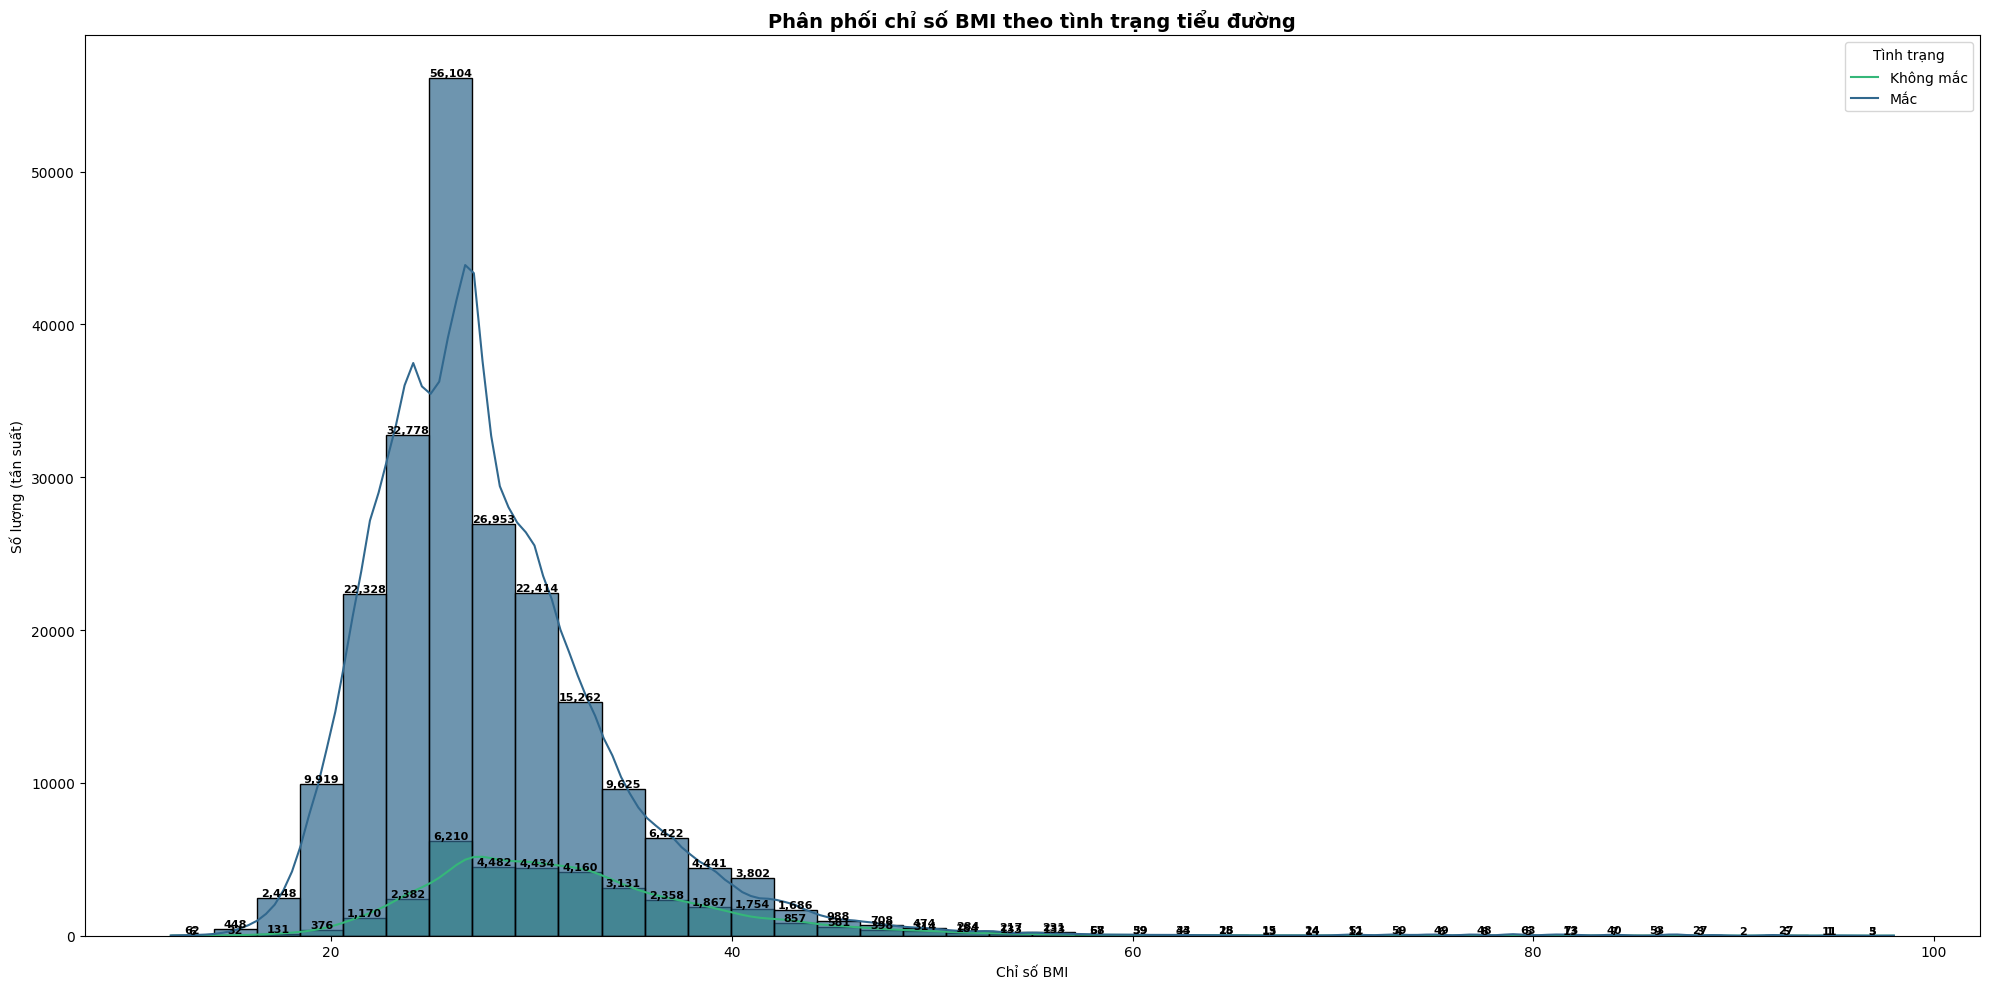

In [17]:
plt.figure(figsize=(20,10))
palette = sns.color_palette("viridis", 2)

# Vẽ biểu đồ phân phối
ax = sns.histplot(
    data=df,
    x="BMI",
    hue="Diabetes_binary",
    kde=True,
    bins=40,
    palette=palette,
    alpha=0.7
)

# Thêm nhãn số lượng trên từng cột
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # tránh ghi lên các cột rỗng
        ax.text(
            patch.get_x() + patch.get_width()/2,
            height,
            f'{int(height):,}',
            ha='center', va='bottom',
            fontsize=8, fontweight='bold'
        )

plt.title("Phân phối chỉ số BMI theo tình trạng tiểu đường", fontsize=14, fontweight='bold')
plt.xlabel("Chỉ số BMI")
plt.ylabel("Số lượng (tần suất)")
plt.legend(title="Tình trạng", labels=["Không mắc", "Mắc"])
plt.tight_layout()
plt.show()

*   **Toàn bộ tập dữ liệu:** Phân bố BMI có dạng hơi lệch phải, với giá trị trung bình khoảng 28.38. Phần lớn dữ liệu nằm trong khoảng BMI từ 20 đến 35. Có sự hiện diện của các giá trị BMI rất cao, cho thấy khả năng có ngoại lai ở phía trên.
*   **Nhóm mắc/tiền tiểu đường:** Phân bố BMI có xu hướng dịch chuyển đáng kể sang phải so với toàn bộ tập dữ liệu. Giá trị trung bình BMI trong nhóm này cao hơn (khoảng 31.94). Điều này cho thấy những người mắc hoặc tiền tiểu đường có xu hướng có BMI cao hơn.

Nhận xét này củng cố mối liên hệ đã biết giữa BMI cao và nguy cơ mắc bệnh tiểu đường.

**So sánh BMI giữa người có và không có tiểu đường**

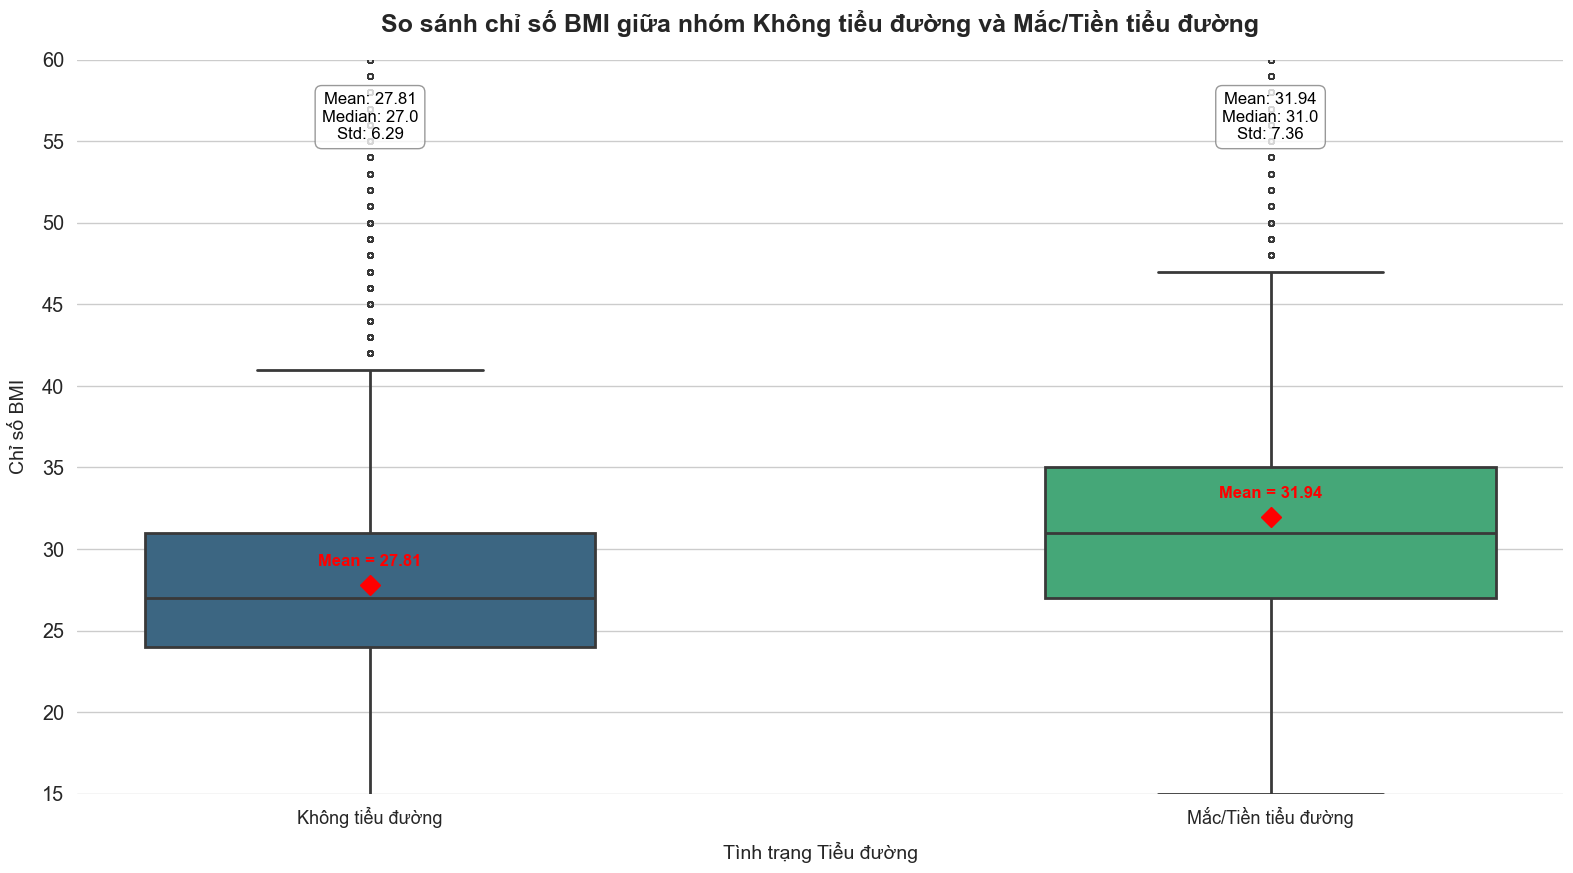

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thiết lập style chung
sns.set_theme(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(16, 9))

palette = sns.color_palette("viridis", 2)

# Vẽ boxplot
ax = sns.boxplot(
    data=df,
    x='Diabetes_binary',
    y='BMI',
    palette=palette,
    hue='Diabetes_binary',
    linewidth=2.0,
    fliersize=4,
    width=0.5,
    legend=False
)

# --- Tùy chỉnh trục & nhãn ---
ax.set_title("So sánh chỉ số BMI giữa nhóm Không tiểu đường và Mắc/Tiền tiểu đường",
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel("Tình trạng Tiểu đường", fontsize=14, labelpad=10)
ax.set_ylabel("Chỉ số BMI", fontsize=14, labelpad=10)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Không tiểu đường", "Mắc/Tiền tiểu đường"], fontsize=13)
plt.ylim(15, 60)

# --- Thêm đường trung bình (mean) ---
means = df.groupby('Diabetes_binary')['BMI'].mean().values
for i, mean in enumerate(means):
    ax.plot(i, mean, marker='D', color='red', markersize=10)
    ax.text(i, mean + 1, f"Mean = {mean:.2f}",
            ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')

# --- Tính và hiển thị các chỉ số ---
bmi_stats = df.groupby('Diabetes_binary')['BMI'].agg(['mean', 'median', 'std']).round(2)

for i, (label, row) in enumerate(bmi_stats.iterrows()):
    ax.text(
        i, 58,  # vị trí đặt text
        f"Mean: {row['mean']}\nMedian: {row['median']}\nStd: {row['std']}",
        ha='center', va='top', fontsize=12,
        color='black',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.4')
    )

# --- Tinh chỉnh bố cục ---
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

	•	BMI trung bình nhóm mắc bệnh cao hơn rõ rệt (≈32 so với ≈28).
	•	Phân bố rộng hơn và có nhiều giá trị ngoại lệ hơn ở nhóm mắc bệnh, phản ánh tình trạng béo phì đa dạng.
	•	Đường Mean màu đỏ cho thấy sự chênh lệch rõ ràng giữa hai nhóm.
	•	Xu hướng này củng cố giả thuyết: BMI càng cao → nguy cơ mắc tiểu đường càng lớn.

**Phân loại BMI thành các nhóm và tính toán tỷ lệ mắc Tiểu đường**

Để có cái nhìn rõ hơn về mối quan hệ giữa các khoảng BMI và nguy cơ tiểu đường, chúng ta sẽ phân loại BMI thành các nhóm theo tiêu chuẩn thông thường và tính toán tỷ lệ người mắc/tiền tiểu đường trong mỗi nhóm.

In [19]:
# Define BMI categories based on standard ranges
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Thiếu cân'
    elif 18.5 <= bmi < 25:
        return 'Bình thường'
    elif 25 <= bmi < 30:
        return 'Thừa cân'
    else:
        return 'Béo phì'

# Create a copy of the DataFrame to avoid modifying the original
df_copy = df.copy()

# Apply the function to create a new 'BMI_Category' column on the copy
df_copy['BMI_Category'] = df_copy['BMI'].apply(bmi_category)

# Calculate the proportion of diabetic patients within each BMI category using the copied DataFrame
bmi_diabetes_proportion = df_copy.groupby('BMI_Category')['Diabetes_binary'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns for clarity
bmi_diabetes_proportion.columns = ['Tỷ lệ Không tiểu đường', 'Tỷ lệ mắc tiểu đường']

# Reorder the index for logical flow
bmi_order = ['Thiếu cân', 'Bình thường', 'Thừa cân', 'Béo phì']
bmi_diabetes_proportion = bmi_diabetes_proportion.reindex(bmi_order)

display(bmi_diabetes_proportion)

,Tỷ lệ Không tiểu đường,Tỷ lệ mắc tiểu đường
BMI_Category,,
Thiếu cân,0.945955,0.054045
Bình thường,0.943034,0.056966
Thừa cân,0.885951,0.114049
Béo phì,0.766002,0.233998


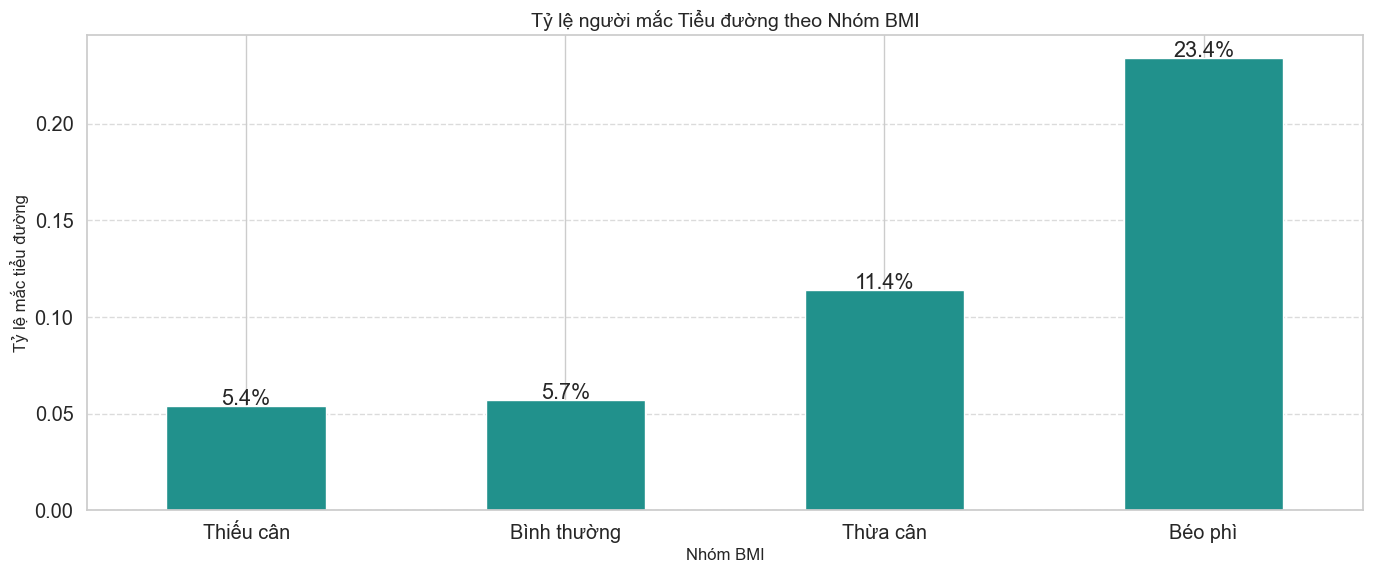

In [20]:
# Plot the proportion of diabetic patients within each BMI category
ax = bmi_diabetes_proportion[['Tỷ lệ mắc tiểu đường']].plot(kind='bar', figsize=(14, 6), color=sns.color_palette('viridis', 1)[0], legend=False)

plt.title('Tỷ lệ người mắc Tiểu đường theo Nhóm BMI', fontsize=14)
plt.xlabel('Nhóm BMI', fontsize=12)
plt.ylabel('Tỷ lệ mắc tiểu đường', fontsize=12)
plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the proportion values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

- Mối liên hệ rõ ràng: Biểu đồ cho thấy một xu hướng tăng dần rõ rệt về tỷ lệ mắc/tiền tiểu đường khi BMI tăng lên.
- Nguy cơ tăng theo nhóm BMI: Tỷ lệ này thấp nhất ở nhóm "Thiếu cân" và "Bình thường", tăng lên đáng kể ở nhóm "Thừa cân", và cao nhất vượt trội ở nhóm "Béo phì".
- Xác nhận yếu tố nguy cơ: Điều này khẳng định lại rằng BMI, đặc biệt là tình trạng thừa cân và béo phì, là một yếu tố nguy cơ rất mạnh mẽ đối với bệnh tiểu đường. Những người có BMI cao hơn có khả năng mắc bệnh tiểu đường cao hơn đáng kể.

### Phân bố các yếu tố sức khỏe và hành vi
•	`HighBP`, `HighChol`, `Smoker`, `HvyAlcoholConsump`, `PhysActivity`

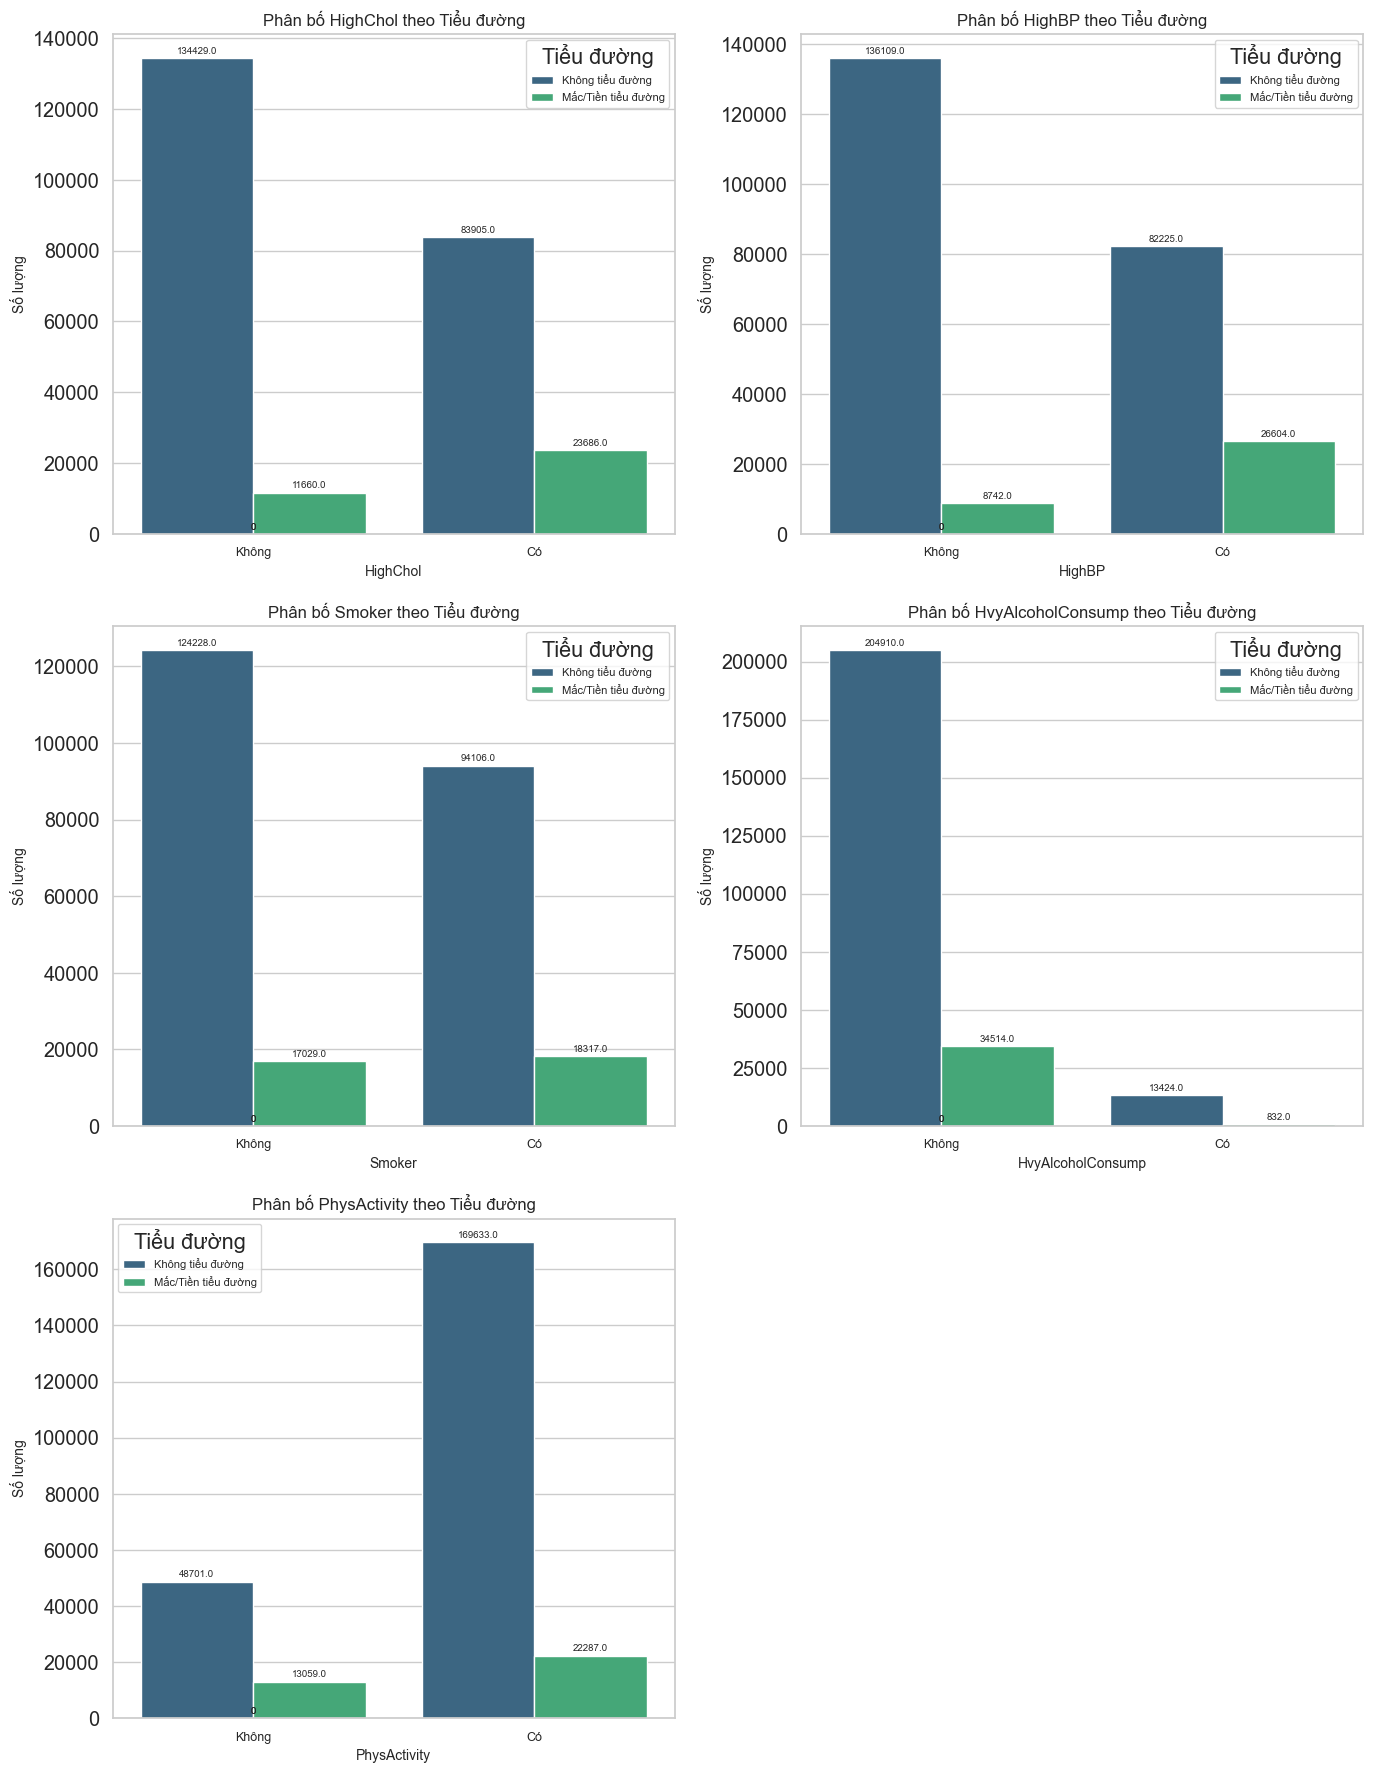

In [21]:
health_behavior_vars = ['HighChol', 'HighBP', 'Smoker', 'HvyAlcoholConsump', 'PhysActivity']
n_vars = len(health_behavior_vars)
n_cols = 2 # Set number of columns to 3 as requested
n_rows = 3 # Set number of rows to 2 as requested

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, var in enumerate(health_behavior_vars):
    ax = axes[i]
    sns.countplot(data=df, x=var, hue='Diabetes_binary', palette='viridis', ax=ax)
    ax.set_title(f'Phân bố {var} theo Tiểu đường', fontsize=12)
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel('Số lượng', fontsize=10)
    ax.set_xticks([0, 1])
    # Adjust labels based on variable meaning (assuming 0=No, 1=Yes for most)
    if var in ['HighBP', 'HighChol', 'Smoker', 'PhysActivity', 'HvyAlcoholConsump']:
        ax.set_xticklabels(['Không', 'Có'], fontsize=9)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ['Không tiểu đường', 'Mắc/Tiền tiểu đường'], title='Tiểu đường', fontsize=8)
    else: # For other binary variables if added later
         handles, labels = ax.get_legend_handles_labels()
         ax.legend(handles, ['Không', 'Có'], title='Diabetes_binary', fontsize=8)

    # Add counts on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=7)


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. Huyết áp cao (HighBP) & Cholesterol cao (HighChol)
   
- Hai yếu tố này có mối liên hệ chặt chẽ với bệnh tiểu đường.
- Số người mắc tiểu đường trong nhóm có huyết áp cao và có cholesterol cao đều cao gấp khoảng 2–3 lần so với nhóm không mắc.
Điều này phản ánh mối liên quan sinh học quen thuộc: các vấn đề tim mạch và rối loạn chuyển hóa thường đi kèm với tiểu đường.

2. Hút thuốc (Smoker)
   
- Tỷ lệ hút thuốc không có sự khác biệt quá lớn giữa hai nhóm, nhưng số người hút thuốc ở nhóm mắc bệnh vẫn cao hơn tương đối.
- Hút thuốc có thể làm tăng kháng insulin, góp phần gia tăng nguy cơ mắc bệnh.

3. Uống rượu bia thường xuyên (HvyAlcoholConsump)
   
- Phần lớn người tham gia không uống nhiều rượu bia (chiếm trên 90%).
- Tuy nhiên, trong nhóm có thói quen uống rượu nặng, tỷ lệ mắc tiểu đường cao hơn đáng kể, cho thấy tác động tiêu cực của việc uống nhiều rượu lên chuyển hóa đường huyết.

4. Hoạt động thể chất (PhysActivity)
   
- Người có hoạt động thể chất thường xuyên chiếm đa số trong cả hai nhóm.
- Tuy vậy, tỷ lệ mắc tiểu đường thấp hơn rõ rệt ở nhóm thường xuyên vận động, trong khi nhóm ít hoạt động có tỷ lệ mắc cao hơn.
- Điều này khẳng định vai trò bảo vệ của lối sống năng động đối với sức khỏe chuyển hóa.

-> Huyết áp cao, cholesterol cao, uống rượu nặng, và thiếu vận động là những hành vi/sức khỏe có liên quan mạnh đến nguy cơ mắc tiểu đường. Ngược lại, duy trì hoạt động thể chất đều đặn giúp giảm đáng kể khả năng mắc bệnh. Các yếu tố này nên được xem là biến giải thích quan trọng trong mô hình dự đoán nguy cơ tiểu đường.

### Phân bố các yếu tố khác liên quan
•	`CholCheck`, `Stroke`, `HeartDiseaseorAttack`, `Fruits`, `Veggies`, `HvyAlcoholConsump`, `AnyHealthcare`, `NoDocbcCost`, `DiffWalk`

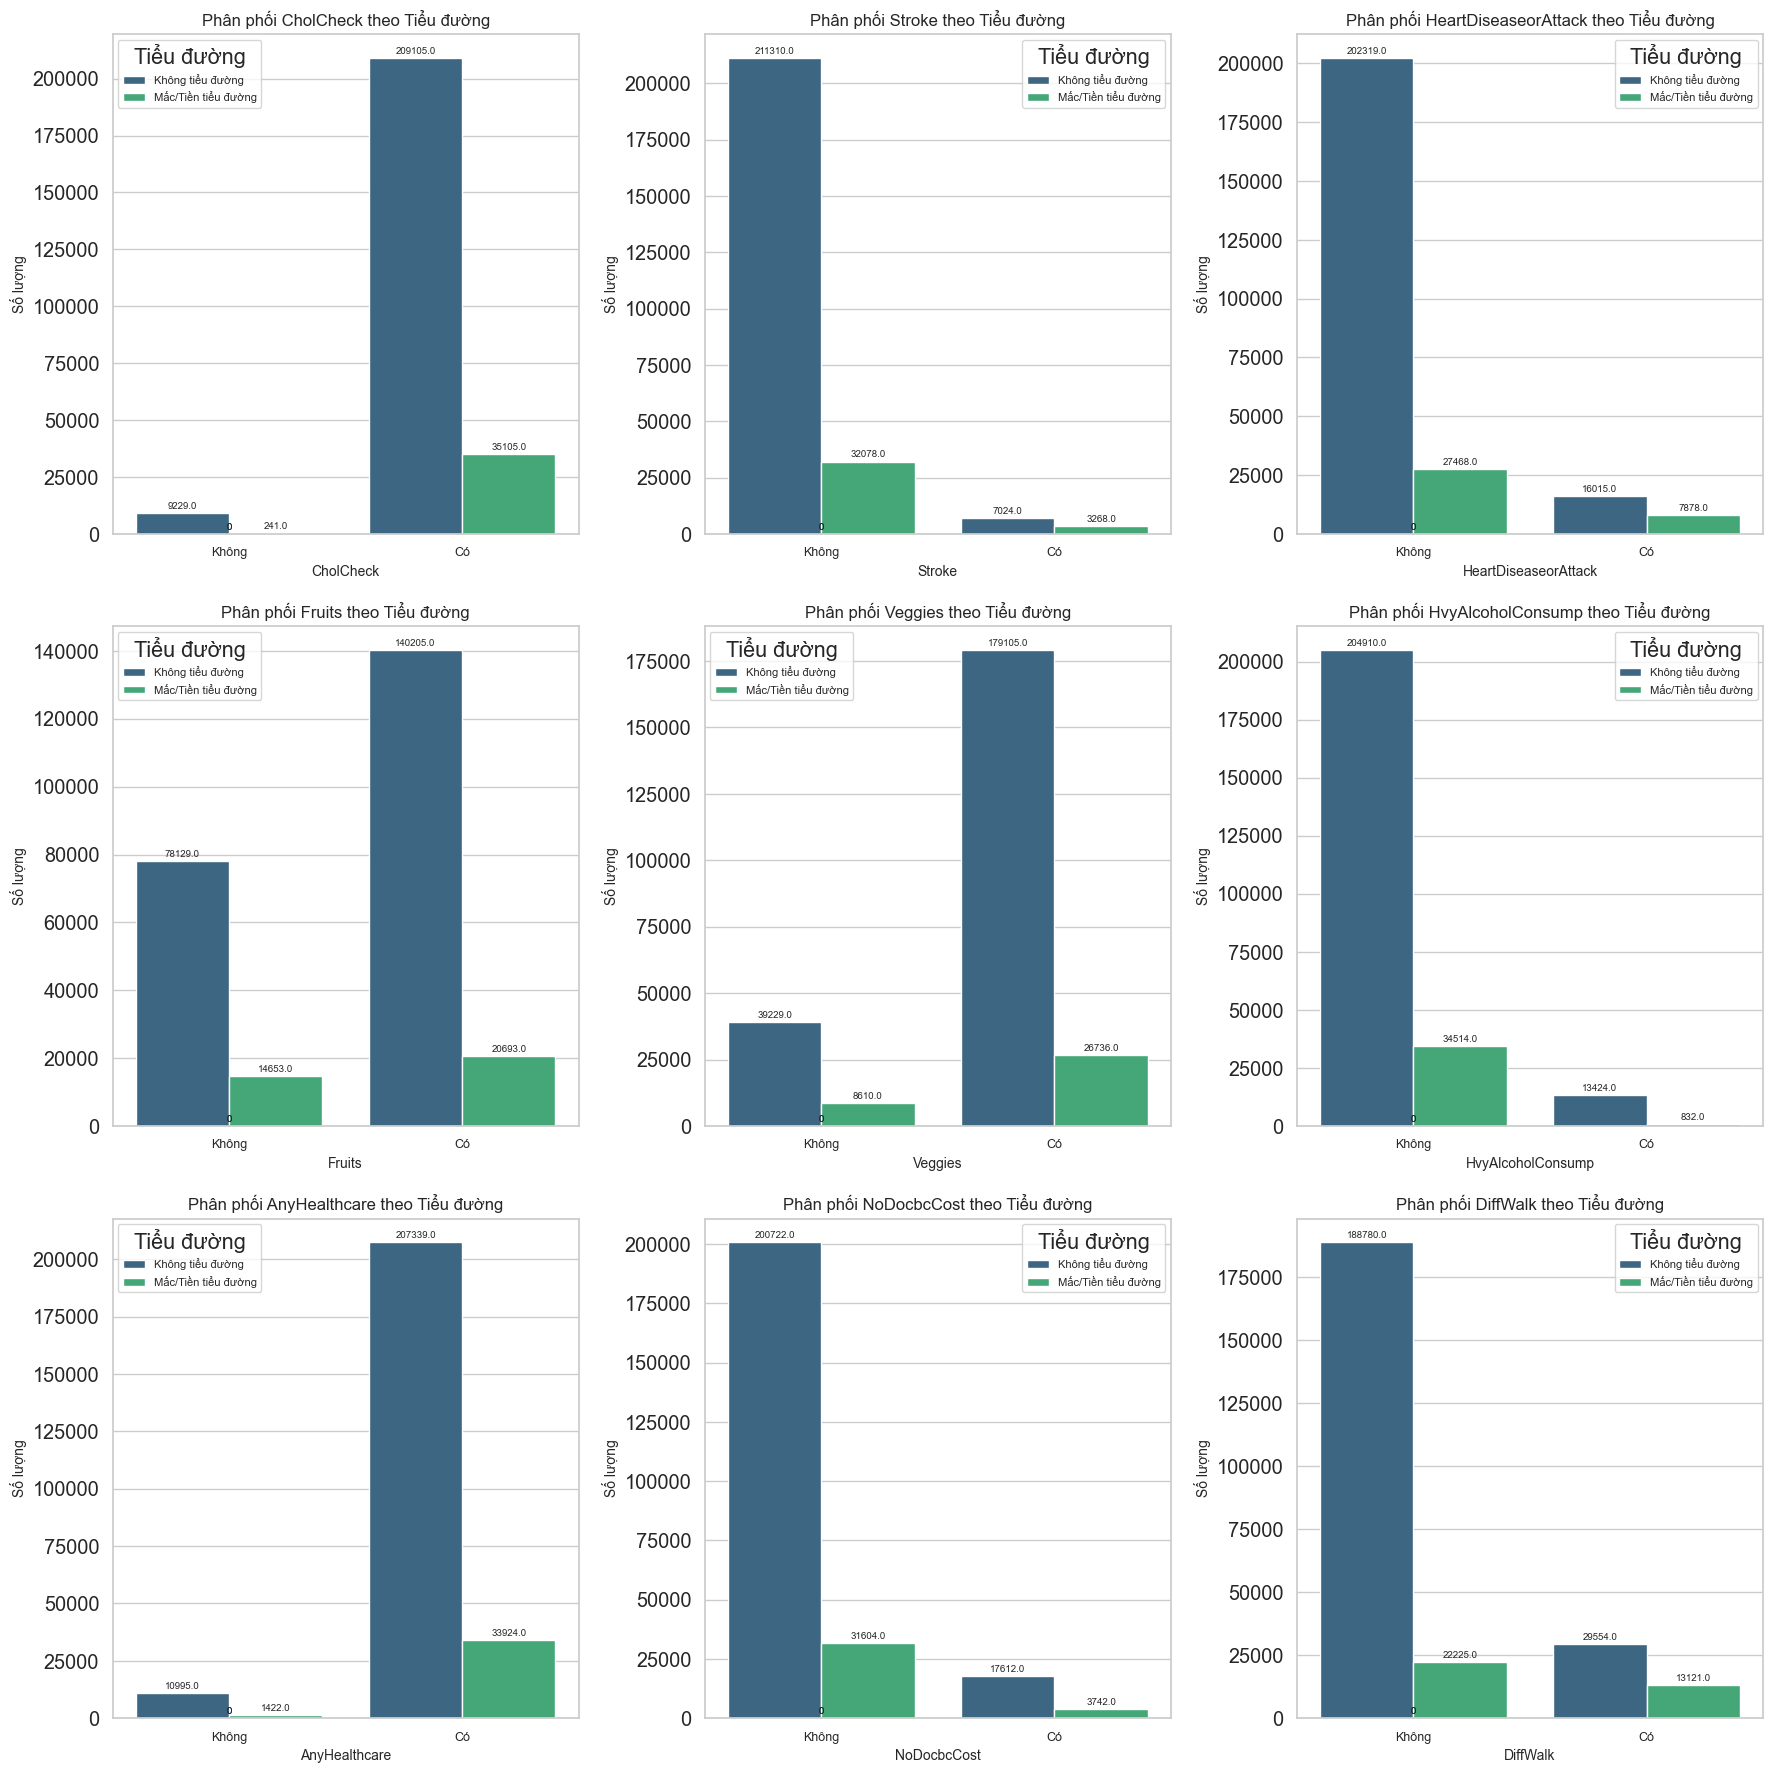

In [22]:
# Remaining binary/categorical variables
other_binary_vars = ['CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'Fruits', 'Veggies',
                     'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

n_vars = len(other_binary_vars)
n_cols = 3 # Number of columns in the grid
n_rows = (n_vars + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, var in enumerate(other_binary_vars):
    ax = axes[i]
    sns.countplot(data=df, x=var, hue='Diabetes_binary', palette='viridis', ax=ax)
    ax.set_title(f'Phân phối {var} theo Tiểu đường', fontsize=12)
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel('Số lượng', fontsize=10)
    ax.set_xticks([0, 1])
    # Adjust labels based on variable meaning (assuming 0=No, 1=Yes for most)
    if var in ['CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'Fruits', 'Veggies',
               'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']:
        ax.set_xticklabels(['Không', 'Có'], fontsize=9)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ['Không tiểu đường', 'Mắc/Tiền tiểu đường'], title='Tiểu đường', fontsize=8)
    else: # For other binary variables if added later
         handles, labels = ax.get_legend_handles_labels()
         ax.legend(handles, ['Không', 'Có'], title='Diabetes_binary', fontsize=8)

    # Add counts on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=7)


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Kiểm tra cholesterol (CholCheck): Phần lớn người tham gia đều đã kiểm tra cholesterol; nhóm có kiểm tra có tỷ lệ mắc tiểu đường cao hơn, phản ánh mối liên hệ giữa theo dõi sức khỏe và phát hiện bệnh.
- Đột quỵ (Stroke) và bệnh tim (HeartDiseaseorAttack): Nhóm có tiền sử đột quỵ hoặc bệnh tim có tỷ lệ mắc tiểu đường cao gấp nhiều lần, cho thấy mối liên hệ mạnh giữa các bệnh tim mạch và tiểu đường.
- Thói quen ăn uống (Fruits, Veggies): Người ăn trái cây và rau thường xuyên có tỷ lệ mắc tiểu đường thấp hơn, khẳng định vai trò của chế độ ăn lành mạnh.
- Bảo hiểm y tế (AnyHealthcare): Hầu hết người tham gia đều có bảo hiểm, cho thấy khả năng tiếp cận dịch vụ y tế tốt trong mẫu dữ liệu.
- Khó khăn tài chính khi khám bệnh (NoDocbcCost): Nhóm gặp khó khăn về chi phí y tế có tỷ lệ mắc tiểu đường cao hơn, phản ánh yếu tố kinh tế ảnh hưởng đến sức khỏe.
- Khó khăn khi đi lại (DiffWalk): Người gặp khó khăn vận động có tỷ lệ mắc tiểu đường cao rõ rệt, chứng tỏ tiểu đường có thể ảnh hưởng đến khả năng vận động và sức khỏe thể chất tổng thể.

### Ma trận tương quan (Correlation Matrix)

In [23]:
# Create a correlation matrix
corr_matrix = df.corr()
# Do some conditional formatting for better readability
cm = sns.light_palette("seagreen", as_cmap=True)
corr_matrix_style = corr_matrix.style.background_gradient(cmap = cm)
corr_matrix_style

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,1.000000,0.263129,0.200276,0.064761,0.216843,0.060789,0.105816,0.177282,-0.118133,-0.040779,-0.056584,-0.057056,0.016255,0.031433,0.293569,0.069315,0.171337,0.218344,0.031430,0.177442,-0.124456,-0.163919
HighBP,0.263129,1.000000,0.298199,0.098508,0.213748,0.096991,0.129575,0.209361,-0.125267,-0.040555,-0.061266,-0.003972,0.038425,0.017358,0.300530,0.056456,0.161212,0.223618,0.052207,0.344452,-0.141358,-0.171235
HighChol,0.200276,0.298199,1.000000,0.085642,0.106722,0.091299,0.092620,0.180765,-0.078046,-0.040859,-0.039874,-0.011543,0.042230,0.013310,0.208426,0.062069,0.121751,0.144672,0.031205,0.272318,-0.070802,-0.085459
CholCheck,0.064761,0.098508,0.085642,1.000000,0.034495,-0.009929,0.024158,0.044206,0.004190,0.023849,0.006121,-0.023730,0.117626,-0.058255,0.046589,-0.008366,0.031775,0.040585,-0.022115,0.090321,0.001510,0.014259
BMI,0.216843,0.213748,0.106722,0.034495,1.000000,0.013804,0.020153,0.052904,-0.147294,-0.087518,-0.062275,-0.048736,-0.018471,0.058206,0.239185,0.085310,0.121141,0.197078,0.042950,-0.036618,-0.103932,-0.100069
Smoker,0.060789,0.096991,0.091299,-0.009929,0.013804,1.000000,0.061173,0.114441,-0.087401,-0.077666,-0.030678,0.101619,-0.023251,0.048946,0.163143,0.092196,0.116460,0.122463,0.093662,0.120641,-0.161955,-0.123937
Stroke,0.105816,0.129575,0.092620,0.024158,0.020153,0.061173,1.000000,0.203002,-0.069151,-0.013389,-0.041124,-0.016950,0.008776,0.034804,0.177942,0.070172,0.148944,0.176567,0.002978,0.126974,-0.076009,-0.128599
HeartDiseaseorAttack,0.177282,0.209361,0.180765,0.044206,0.052904,0.114441,0.203002,1.000000,-0.087299,-0.019790,-0.039167,-0.028991,0.018734,0.031000,0.258383,0.064621,0.181698,0.212709,0.086096,0.221618,-0.099600,-0.141011
PhysActivity,-0.118133,-0.125267,-0.078046,0.004190,-0.147294,-0.087401,-0.069151,-0.087299,1.000000,0.142756,0.153150,0.012392,0.035505,-0.061638,-0.266186,-0.125587,-0.219230,-0.253174,0.032482,-0.092511,0.199658,0.198539
Fruits,-0.040779,-0.040555,-0.040859,0.023849,-0.087518,-0.077666,-0.013389,-0.019790,0.142756,1.000000,0.254342,-0.035288,0.031544,-0.044243,-0.103854,-0.068217,-0.044633,-0.048352,-0.091175,0.064547,0.110187,0.079929


**Trực quan hóa Ma trận Tương quan (Correlation Heatmap)**

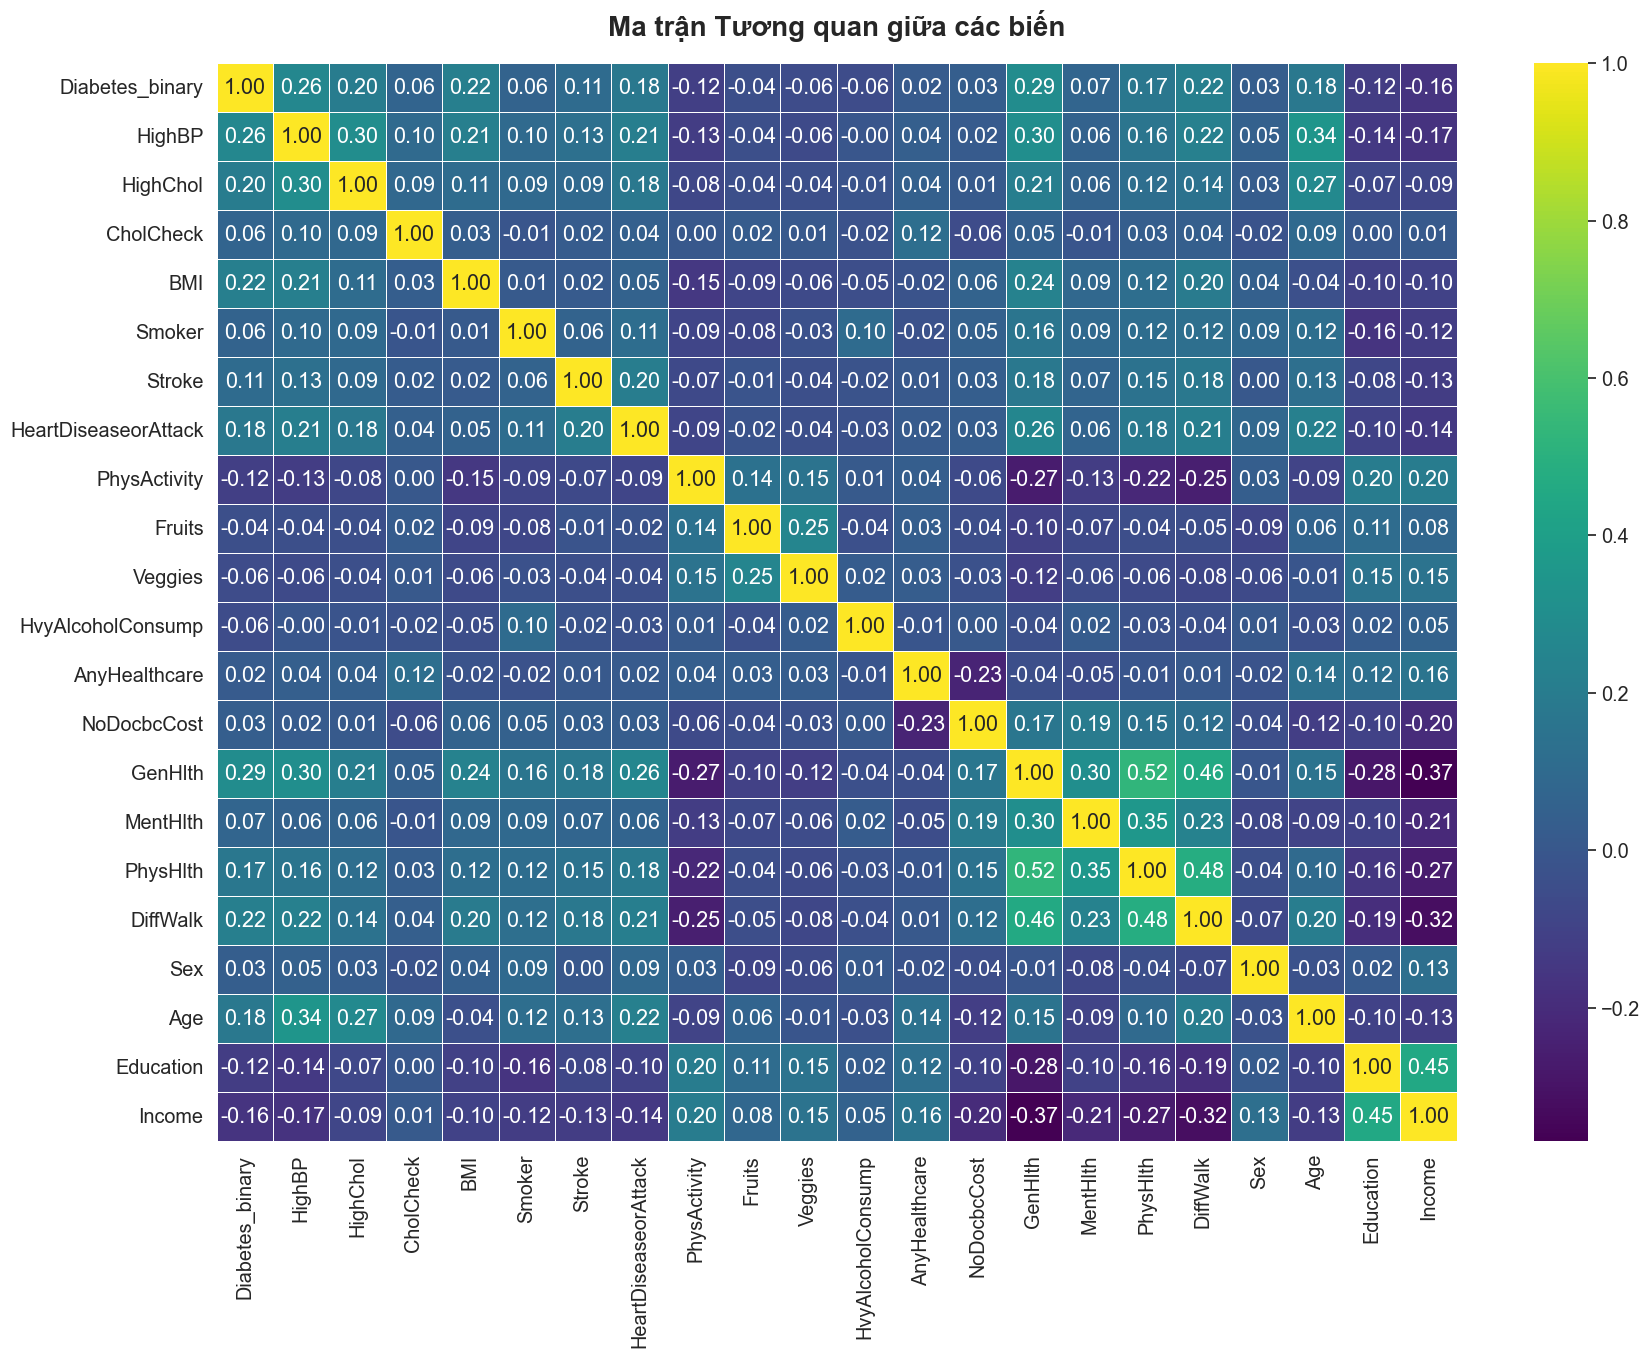

In [24]:
plt.figure(figsize=(20, 14)) # Điều chỉnh kích thước biểu đồ cho phù hợp
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Ma trận Tương quan giữa các biến', fontsize=20, fontweight='bold', pad=20)
plt.show()

Dựa trên biểu đồ nhiệt của ma trận tương quan và bảng xếp hạng mức độ tương quan (giá trị tuyệt đối) với biến mục tiêu `Diabetes_binary`, chúng ta có thể đưa ra các nhận xét sau:

**Các yếu tố có Tương quan Dương mạnh nhất với Tiểu đường:**

Các biến có giá trị tương quan dương cao nhất với `Diabetes_binary` là những yếu tố có xu hướng tăng khi nguy cơ mắc bệnh tiểu đường tăng lên. Theo bảng xếp hạng, các yếu tố này là:

1.  **`GenHlth` (Sức khỏe chung):** Có tương quan dương mạnh nhất (khoảng 0.29). Điều này khẳng định những người tự đánh giá sức khỏe ở mức kém hơn có nguy cơ mắc tiểu đường cao hơn đáng kể.
2.  **`HighBP` (Huyết áp cao):** Tương quan dương đáng kể (khoảng 0.26). Huyết áp cao là một yếu tố nguy cơ kinh điển của nhiều bệnh, bao gồm cả tiểu đường.
3.  **`DiffWalk` (Khó khăn khi đi lại):** Tương quan dương mạnh (khoảng 0.22). Biến này thường liên quan đến các biến chứng hoặc tình trạng sức khỏe nền tảng khác, có mối liên hệ chặt chẽ với tiểu đường.
4.  **`BMI` (Chỉ số BMI):** Tương quan dương đáng kể (khoảng 0.22). BMI cao, đặc biệt là béo phì, là một trong những yếu tố nguy cơ quan trọng nhất của bệnh tiểu đường loại 2.
5.  **`HighChol` (Cholesterol cao):** Tương quan dương (khoảng 0.20). Tương tự như huyết áp cao, cholesterol cao thường đi kèm và làm tăng nguy cơ mắc tiểu đường.

Các biến khác như `Age`, `HeartDiseaseorAttack`, và `PhysHlth` cũng cho thấy tương quan dương đáng kể (khoảng 0.17 - 0.18) với `Diabetes_binary`, điều này phù hợp với hiểu biết y tế.

**Các yếu tố có Tương quan Âm với Tiểu đường:**

Các biến có tương quan âm với `Diabetes_binary` là những yếu tố có xu hướng giảm khi nguy cơ mắc bệnh tiểu đường tăng lên (hoặc ngược lại). Các biến này chủ yếu liên quan đến các yếu tố kinh tế xã hội hoặc hành vi tích cực:

1.  **`Income` (Thu nhập):** Tương quan âm đáng kể (khoảng -0.16). Điều này gợi ý rằng người có thu nhập thấp hơn có nguy cơ mắc tiểu đường cao hơn.
2.  **`Education` (Giáo dục):** Tương quan âm (khoảng -0.12). Trình độ học vấn thấp hơn cũng có vẻ liên quan đến nguy cơ tiểu đường cao hơn.
3.  **`PhysActivity` (Hoạt động thể chất):** Tương quan âm (khoảng -0.12). Điều này khẳng định hoạt động thể chất thường xuyên giúp giảm nguy cơ mắc bệnh tiểu đường.

**Mối tương quan giữa các Biến Dự báo:**

Heatmap cũng cho thấy mối tương quan đáng chú ý giữa một số biến dự báo với nhau:

*   Có tương quan dương mạnh mẽ giữa `GenHlth`, `DiffWalk`, `PhysHlth`. Điều này hợp lý vì sức khỏe chung kém, khó khăn khi đi lại và nhiều ngày sức khỏe thể chất không tốt thường đi kèm với nhau.
*   `Age` có tương quan dương với nhiều biến sức khỏe tiêu cực khác như `HighBP`, `HighChol`, `HeartDiseaseorAttack`, `DiffWalk`, phản ánh tác động của tuổi tác lên sức khỏe.
*   `Education` và `Income` có tương quan dương khá mạnh với nhau (khoảng 0.45) và tương quan âm với nhiều biến sức khỏe tiêu cực, làm nổi bật vai trò của các yếu tố kinh tế xã hội.

**Kết luận:** Ma trận tương quan giúp xác định nhanh chóng các biến có mối quan hệ tuyến tính mạnh nhất với biến mục tiêu và giữa các biến dự báo với nhau. Các biến như `GenHlth`, `HighBP`, `DiffWalk`, `BMI`, `HighChol`, `Age`, `HeartDiseaseorAttack`, `PhysHlth` là những ứng cử viên tiềm năng là các yếu tố dự báo quan trọng cho mô hình. Các biến liên quan đến kinh tế xã hội (`Income`, `Education`) và hành vi (`PhysActivity`) cũng cho thấy mối liên hệ, mặc dù ở mức độ tương quan tuyến tính thấp hơn.

### Mức độ tương quan với biến mục tiêu

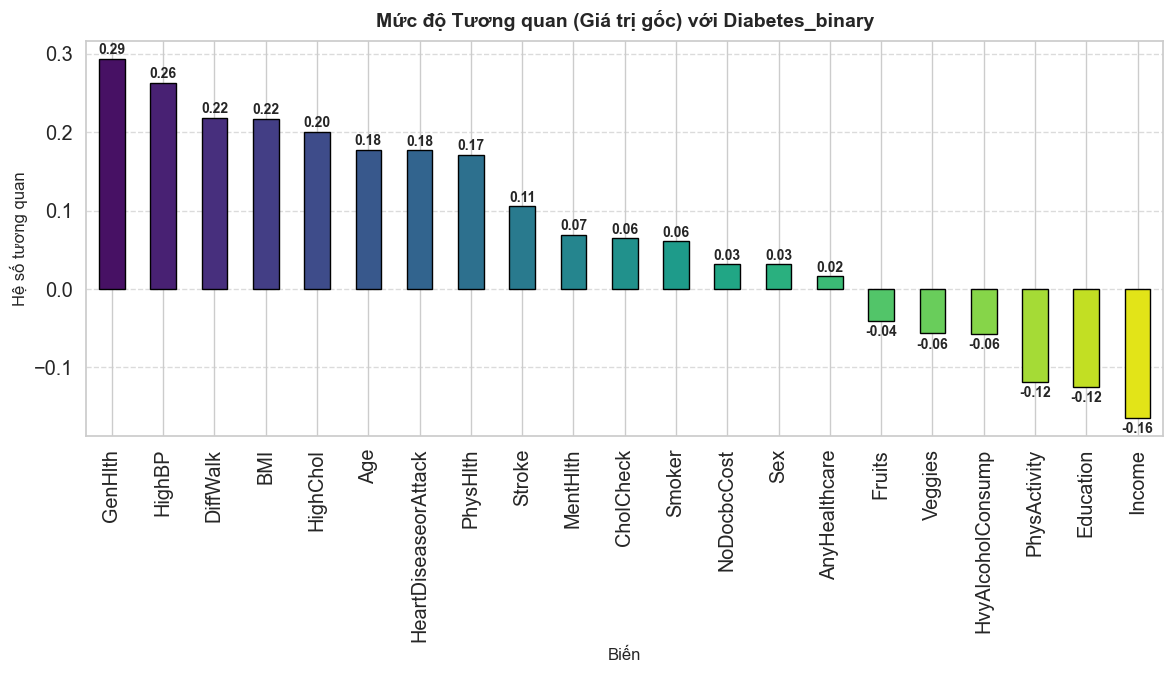

In [25]:
# Trích xuất tương quan giữa các biến và biến mục tiêu
correlation_with_diabetes = corr_matrix['Diabetes_binary'].drop('Diabetes_binary')
ranked_correlation = correlation_with_diabetes.sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(12, 7))
ax = ranked_correlation.plot(
    kind='bar',
    color=sns.color_palette('viridis', len(ranked_correlation)),
    edgecolor='black'
)

plt.title('Mức độ Tương quan (Giá trị gốc) với Diabetes_binary', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Biến', fontsize=12)
plt.ylabel('Hệ số tương quan', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(ranked_correlation):
    ax.text(
        i, v + 0.002 if v >= 0 else v - 0.005, 
        f'{v:.2f}', ha='center',
        va='bottom' if v >= 0 else 'top',
        fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.show()

- Các biến có tương quan dương mạnh nhất với khả năng mắc tiểu đường gồm: GenHlth (0.29), HighBP (0.26), DiffWalk (0.22) và BMI (0.22)
  
  → cho thấy sức khỏe kém, huyết áp cao, khó vận động và béo phì là những yếu tố nguy cơ rõ rệt.
  
- Age (0.18) và HeartDiseaseorAttack (0.17) cũng có mối liên hệ cùng chiều, phản ánh ảnh hưởng của tuổi tác và bệnh tim mạch.
- Các biến PhysActivity (-0.12), Education (-0.12) và Income (-0.16) có tương quan âm, nghĩa là người vận động thường xuyên, học vấn và thu nhập cao có nguy cơ mắc tiểu đường thấp hơn.

**Tổng hợp Quan sát Chi tiết từ giai đoạn Khám phá dữ liệu**

Dựa trên các phân tích trực quan và tương quan đã thực hiện, chúng ta có những quan sát chi tiết sau về mối quan hệ giữa các đặc trưng và tình trạng tiểu đường:

1.  **Phân bố Biến Mục tiêu (`Diabetes_binary`):** Dữ liệu cho thấy sự mất cân bằng lớp nghiêm trọng, với chỉ khoảng 13.9% mẫu thuộc lớp dương (mắc/tiền tiểu đường) và 86.1% thuộc lớp âm (không tiểu đường). Điều này cần được xử lý trong giai đoạn tiền xử lý.
2.  **Giới tính (`Sex`):** Mặc dù số lượng nữ giới trong tập dữ liệu nhiều hơn, tỷ lệ nam giới mắc hoặc tiền tiểu đường có vẻ cao hơn so với nữ giới khi xem xét phân bố theo tình trạng tiểu đường. Tuy nhiên, tương quan tuyến tính với biến mục tiêu khá yếu (khoảng 0.03).
3.  **Tuổi tác (`Age`):** Tuổi tác là một yếu tố nguy cơ mạnh mẽ. Tỷ lệ và số lượng người mắc/tiền tiểu đường tăng lên đáng kể ở các nhóm tuổi cao hơn, đặc biệt tập trung ở các nhóm từ 60 tuổi trở lên. Tương quan dương đáng kể (khoảng 0.18).
4.  **Chỉ số BMI (`BMI`):** Phân bố BMI trong nhóm mắc/tiền tiểu đường dịch chuyển đáng kể sang phải so với nhóm không mắc, với giá trị trung bình cao hơn. Biểu đồ box plot và phân loại BMI cho thấy tỷ lệ mắc tiểu đường tăng rõ rệt theo nhóm BMI, cao nhất ở nhóm "Béo phì". Tương quan dương đáng kể (khoảng 0.22).
5.  **Huyết áp cao (`HighBP`) và Cholesterol cao (`HighChol`):** Cả hai yếu tố này đều có tương quan dương đáng kể với `Diabetes_binary` (khoảng 0.26 và 0.20). Phân bố cho thấy tỷ lệ người mắc tiểu đường cao hơn rõ rệt trong nhóm có huyết áp cao và/hoặc cholesterol cao.
6.  **Sức khỏe chung (`GenHlth`):** Đây là biến có tương quan dương mạnh nhất với `Diabetes_binary` (khoảng 0.29). Những người tự đánh giá sức khỏe ở mức kém hơn có nguy cơ mắc tiểu đường cao hơn đáng kể.
7.  **Khó khăn khi đi lại (`DiffWalk`):** Biến này cũng có tương quan dương mạnh (khoảng 0.22) và phân bố cho thấy tỷ lệ mắc tiểu đường cao hơn ở nhóm gặp khó khăn khi đi lại.
8.  **Sức khỏe thể chất (`PhysHlth`) và Tinh thần (`MentHlth`):** Cả hai đều có tương quan dương với `Diabetes_binary` (khoảng 0.17 và 0.07). Số ngày sức khỏe không tốt (cả thể chất và tinh thần) có xu hướng cao hơn ở nhóm mắc tiểu đường, mặc dù `MentHlth` có tương quan tuyến tính yếu hơn. Cả hai biến này cũng có nhiều giá trị ngoại lai.
9.  **Hoạt động thể chất (`PhysActivity`):** Có tương quan âm đáng kể (khoảng -0.12), khẳng định rằng hoạt động thể chất thường xuyên giúp giảm nguy cơ.
10. **Thu nhập (`Income`) và Giáo dục (`Education`):** Cả hai đều có tương quan âm đáng kể với `Diabetes_binary` (khoảng -0.16 và -0.12), cho thấy các yếu tố kinh tế xã hội đóng vai trò trong nguy cơ mắc bệnh.
11. **Hút thuốc (`Smoker`) và Uống rượu nặng (`HvyAlcoholConsump`):** Tương quan tuyến tính với `Diabetes_binary` khá yếu (khoảng 0.06 và -0.06). Mặc dù là các yếu tố nguy cơ sức khỏe nói chung, mối liên hệ tuyến tính trực tiếp với tiểu đường trong tập dữ liệu này không mạnh bằng các yếu tố khác.
12. **Kiểm tra Cholesterol (`CholCheck`) và Có bảo hiểm y tế (`AnyHealthcare`):** Các biến này có tỷ lệ "Có" rất cao và tương quan tuyến tính rất yếu với `Diabetes_binary` (khoảng 0.06 và 0.02).
13. **Không đủ tiền khám bác sĩ (`NoDocbcCost`):** Tương quan tuyến tính yếu (khoảng 0.03).
14. **Tiêu thụ Trái cây (`Fruits`) và Rau củ (`Veggies`):** Cả hai đều có tương quan âm yếu với `Diabetes_binary` (khoảng -0.04 và -0.06).

Những quan sát này sẽ là cơ sở quan trọng để lựa chọn các đặc trưng cho mô hình và quyết định các bước tiền xử lý dữ liệu phù hợp.

## Đánh giá chất lượng dữ liệu

### Kiểm tra giá trị hợp lệ của biến phân loại và biến thứ bậc

In [26]:
# Define expected value ranges based on the data dictionary
expected_values = {
    'Diabetes_binary': [0.0, 1.0],
    'HighBP': [0.0, 1.0],
    'HighChol': [0.0, 1.0],
    'CholCheck': [0.0, 1.0],
    'Smoker': [0.0, 1.0],
    'Stroke': [0.0, 1.0],
    'HeartDiseaseorAttack': [0.0, 1.0],
    'PhysActivity': [0.0, 1.0],
    'Fruits': [0.0, 1.0],
    'Veggies': [0.0, 1.0],
    'HvyAlcoholConsump': [0.0, 1.0],
    'AnyHealthcare': [0.0, 1.0],
    'NoDocbcCost': [0.0, 1.0],
    'DiffWalk': [0.0, 1.0],
    'Sex': [0.0, 1.0],
    'GenHlth': [1.0, 2.0, 3.0, 4.0, 5.0],
    'Age': list(range(1, 14)), # 1.0 to 13.0
    'Education': list(range(1, 7)), # 1.0 to 6.0
    'Income': list(range(1, 9)) # 1.0 to 8.0
}

# Check for unexpected values in each column
print("Kiểm tra các giá trị không mong đợi trong các biến phân loại/thang đo thứ bậc:")
for col, values in expected_values.items():
    unexpected_values = df[~df[col].isin(values)][col].unique()
    if len(unexpected_values) > 0:
        print(f"  - Cột '{col}': Tìm thấy các giá trị không mong đợi: {unexpected_values}")
    else:
        print(f"  - Cột '{col}': Tất cả giá trị đều hợp lệ.")

Kiểm tra các giá trị không mong đợi trong các biến phân loại/thang đo thứ bậc:
  - Cột 'Diabetes_binary': Tất cả giá trị đều hợp lệ.
  - Cột 'HighBP': Tất cả giá trị đều hợp lệ.
  - Cột 'HighChol': Tất cả giá trị đều hợp lệ.
  - Cột 'CholCheck': Tất cả giá trị đều hợp lệ.
  - Cột 'Smoker': Tất cả giá trị đều hợp lệ.
  - Cột 'Stroke': Tất cả giá trị đều hợp lệ.
  - Cột 'HeartDiseaseorAttack': Tất cả giá trị đều hợp lệ.
  - Cột 'PhysActivity': Tất cả giá trị đều hợp lệ.
  - Cột 'Fruits': Tất cả giá trị đều hợp lệ.
  - Cột 'Veggies': Tất cả giá trị đều hợp lệ.
  - Cột 'HvyAlcoholConsump': Tất cả giá trị đều hợp lệ.
  - Cột 'AnyHealthcare': Tất cả giá trị đều hợp lệ.
  - Cột 'NoDocbcCost': Tất cả giá trị đều hợp lệ.
  - Cột 'DiffWalk': Tất cả giá trị đều hợp lệ.
  - Cột 'Sex': Tất cả giá trị đều hợp lệ.
  - Cột 'GenHlth': Tất cả giá trị đều hợp lệ.
  - Cột 'Age': Tất cả giá trị đều hợp lệ.
  - Cột 'Education': Tất cả giá trị đều hợp lệ.
  - Cột 'Income': Tất cả giá trị đều hợp lệ.


### Phát hiện và đánh giá giá trị ngoại lai (Outliers)

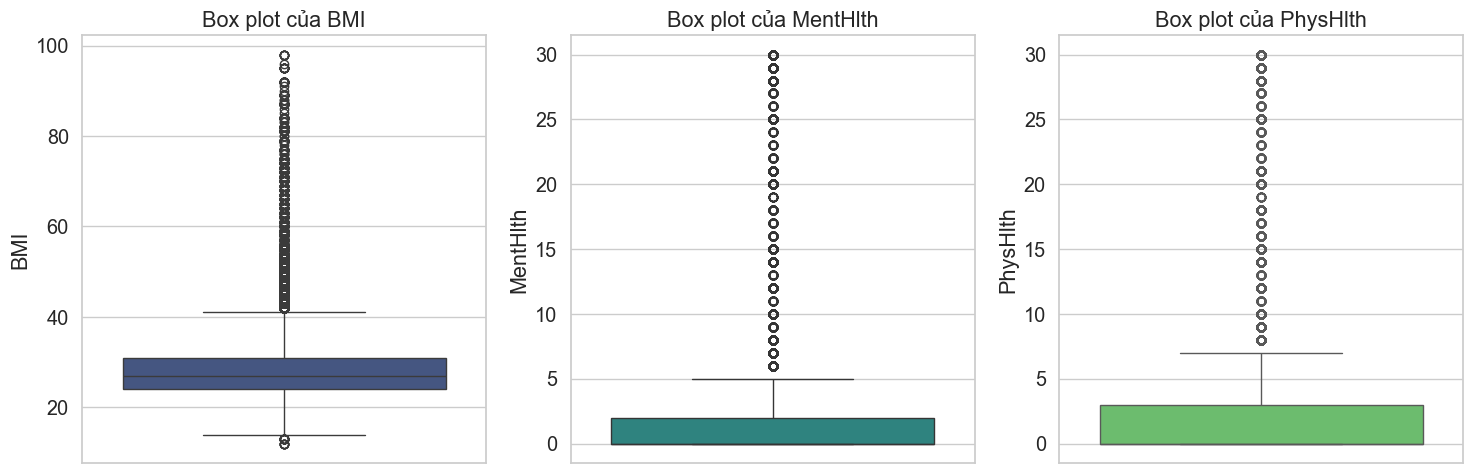

In [27]:
continuous_vars = ['BMI', 'MentHlth', 'PhysHlth']

plt.figure(figsize=(15, 5))
# Define a list of colors from the viridis palette
colors = sns.color_palette('viridis', len(continuous_vars))

for i, var in enumerate(continuous_vars):
    plt.subplot(1, 3, i + 1)
    # Use the 'color' argument with the defined palette
    sns.boxplot(y=df[var], color=colors[i])
    plt.title(f'Box plot của {var}')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

Dựa trên các biểu đồ box plot cho các biến số `BMI`, `MentHlth`, và `PhysHlth`:

*   **`BMI`:** Biểu đồ cho thấy có nhiều điểm dữ liệu nằm rất xa so với phần lớn phân bố (các điểm nằm ngoài "râu" của box plot), đặc biệt là ở phía giá trị cao. Điều này xác nhận sự hiện diện của các giá trị BMI rất cao, được coi là ngoại lai.
*   **`MentHlth`:** Biểu đồ `MentHlth` cho thấy phần lớn người tham gia khảo sát báo cáo 0 ngày sức khỏe tinh thần không tốt. Tuy nhiên, có một lượng đáng kể các điểm dữ liệu nằm rải rác ở các giá trị cao hơn, kéo dài đến 30 ngày. Những giá trị cao này được xem là ngoại lai so với phân bố chính tập trung ở 0.
*   **`PhysHlth`:** Tương tự như `MentHlth`, biểu đồ `PhysHlth` cũng có phần lớn dữ liệu tập trung ở 0 ngày sức khỏe thể chất không tốt, nhưng có nhiều điểm dữ liệu ngoại lai ở các giá trị cao, kéo dài đến 30 ngày.

**Kết luận:** Cả ba biến `BMI`, `MentHlth`, và `PhysHlth` đều chứa các giá trị ngoại lai đáng chú ý ở phía trên. Việc xử lý các giá trị ngoại lai này sẽ là một phần quan trọng trong giai đoạn tiền xử lý dữ liệu để đảm bảo chúng không ảnh hưởng tiêu cực đến hiệu suất của mô hình dự đoán.

# Chuẩn bị dữ liệu (Data Preparation)

## Làm sạch dữ liệu (Data Cleaning)

### Xử lý bản ghi trùng lặp

In [28]:
# Kiểm tra lại số bản ghi trùng lặp
duplicate_rows = df.duplicated().sum()
print(f"Số dòng trùng lặp trong tập dữ liệu: {duplicate_rows}")

# Nếu có trùng lặp → loại bỏ
if duplicate_rows > 0:
    df = df.drop_duplicates()
    print(f"Đã loại bỏ {duplicate_rows} dòng trùng lặp.")
else:
    print("Không có bản ghi trùng lặp trong tập dữ liệu.")

Số dòng trùng lặp trong tập dữ liệu: 24206
Đã loại bỏ 24206 dòng trùng lặp.


### Xử lý giá trị ngoại lai (Outliers)

In [29]:
# Kiểm tra bằng boxplot đối với các biến liên tục
continuous_vars = ['BMI', 'MentHlth', 'PhysHlth']

for col in continuous_vars:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    before = len(df)
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = len(df)
    print(f"{col}: Loại bỏ {before - after} giá trị ngoại lai.")

BMI: Loại bỏ 5638 giá trị ngoại lai.
MentHlth: Loại bỏ 34542 giá trị ngoại lai.
PhysHlth: Loại bỏ 28499 giá trị ngoại lai.


Các biến liên tục như BMI, MentHlth, PhysHlth có xuất hiện một số giá trị ngoại lai.
Tuy nhiên, các giá trị này phản ánh thực tế (ví dụ: BMI cao ở người béo phì) nên chỉ loại bỏ các điểm cực đoan vượt quá ngưỡng IQR 1.5 để tránh mất thông tin.

## Biến đổi và Tạo đặc trưng (Data Transformation & Feature Engineering)

### Chuẩn hóa kiểu dữ liệu

In [30]:
import numpy as np
import pandas as pd

# 1) Định nghĩa nhóm biến
target_col = 'Diabetes_binary'
continuous_cols = ['BMI', 'MentHlth', 'PhysHlth']  # số thực/liên tục
ordinal_int_cols = ['Age', 'Education', 'Income', 'GenHlth']  # thang bậc (1..n)
binary_cols = [
    'HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack',
    'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare',
    'NoDocbcCost','DiffWalk','Sex'
]

# 2) Ép kiểu an toàn
# 2.1 Liên tục
df[continuous_cols] = df[continuous_cols].apply(pd.to_numeric, errors='coerce').astype('float32')

# 2.2 Thang bậc (giữ số nguyên)
df[ordinal_int_cols] = df[ordinal_int_cols].apply(pd.to_numeric, errors='coerce').astype('int16')

# 2.3 Nhị phân (đảm bảo 0/1, kiểu int8)
def to_binary01(s: pd.Series) -> pd.Series:
    # Nếu có giá trị khác 0/1 (ví dụ 0.0/1.0) thì quy chuẩn về 0/1
    s = pd.to_numeric(s, errors='coerce')
    # Ngưỡng 0.5 để xử lý trường hợp float
    s = (s >= 0.5).astype('int8')
    return s

for c in binary_cols + [target_col]:
    df[c] = to_binary01(df[c])

# 3) Kiểm tra phạm vi hợp lệ (optional nhưng nên có)
# MentHlth/PhysHlth: 0..30 ngày
for c in ['MentHlth','PhysHlth']:
    invalid = (~df[c].between(0, 30)).sum()
    if invalid:
        print(f"⚠️ {c}: {invalid} giá trị ngoài khoảng 0–30. Sẽ clip về [0,30].")
        df[c] = df[c].clip(lower=0, upper=30)

# Age: 1..13 theo mô tả
invalid_age = (~df['Age'].between(1, 13)).sum()
if invalid_age:
    print(f"⚠️ Age: {invalid_age} giá trị ngoài khoảng 1–13. Sẽ clip về [1,13].")
    df['Age'] = df['Age'].clip(lower=1, upper=13)

# GenHlth: 1..5
invalid_gen = (~df['GenHlth'].between(1, 5)).sum()
if invalid_gen:
    print(f"⚠️ GenHlth: {invalid_gen} giá trị ngoài khoảng 1–5. Sẽ clip về [1,5].")
    df['GenHlth'] = df['GenHlth'].clip(lower=1, upper=5)

# 4) Báo cáo tóm tắt kiểu dữ liệu sau chuẩn hóa
print("\n📦 Kiểu dữ liệu sau chuẩn hóa:")
print(df.dtypes)

# 5) Sanity checks ngắn
assert set(df[target_col].unique()).issubset({0,1}), "Target phải là nhị phân 0/1"
for c in binary_cols:
    assert set(df[c].unique()).issubset({0,1}), f"{c} phải là nhị phân 0/1"
print("✅ Kiểm tra nhị phân 0/1: OK")


📦 Kiểu dữ liệu sau chuẩn hóa:
Diabetes_binary            int8
HighBP                     int8
HighChol                   int8
CholCheck                  int8
BMI                     float32
Smoker                     int8
Stroke                     int8
HeartDiseaseorAttack       int8
PhysActivity               int8
Fruits                     int8
Veggies                    int8
HvyAlcoholConsump          int8
AnyHealthcare              int8
NoDocbcCost                int8
GenHlth                   int16
MentHlth                float32
PhysHlth                float32
DiffWalk                   int8
Sex                        int8
Age                       int16
Education                 int16
Income                    int16
dtype: object
✅ Kiểm tra nhị phân 0/1: OK


### Tạo đặc trưng (Feature Engineering)

In [31]:
# BMI Categories theo CDC
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# 1) BMI_cat (text), 2) Tương tác BMI×Age, 3) Nhóm nguy cơ cao (Obese & Age>=10 ~ 65+)
df['BMI_cat'] = df['BMI'].apply(bmi_category)
df['BMI_Age_interaction'] = df['BMI'] * df['Age']
df['HighRisk_Obese_Old'] = ((df['BMI_cat'] == 'Obese') & (df['Age'] >= 10)).astype(int)

# Mã hóa thứ bậc cho BMI_cat (đưa về một cột code thứ bậc để pipeline xử lý gọn)
df['BMI_cat_code'] = pd.Categorical(
    df['BMI_cat'],
    categories=['Underweight','Normal','Overweight','Obese'],
    ordered=True
).codes

# Không cần giữ cột text nếu đã có code
df = df.drop(columns=['BMI_cat'])

In [32]:
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_Age_interaction,HighRisk_Obese_Old,BMI_cat_code
1,0,0,0,0,25.0,1,0,0,1,0,0,0,0,1,3,0.0,0.0,0,0,7,6,1,175.0,0,2
3,0,1,0,1,27.0,0,0,0,1,1,1,0,1,0,2,0.0,0.0,0,0,11,3,6,297.0,0,2
4,0,1,1,1,24.0,0,0,0,1,1,1,0,1,0,2,3.0,0.0,0,0,11,5,4,264.0,0,1
5,0,1,1,1,25.0,1,0,0,1,1,1,0,1,0,2,0.0,2.0,0,1,10,6,8,250.0,0,2
7,0,1,1,1,25.0,1,0,0,1,0,1,0,1,0,3,0.0,0.0,1,0,11,4,4,275.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253674,0,0,0,1,27.0,0,0,0,0,0,1,0,1,0,1,0.0,0.0,0,0,3,6,5,81.0,0,2
253676,1,1,1,1,18.0,0,0,0,0,0,0,0,1,0,4,0.0,0.0,1,0,11,2,4,198.0,0,0
253677,0,0,0,1,28.0,0,0,0,1,1,0,0,1,0,1,0.0,0.0,0,0,2,5,2,56.0,0,2
253678,0,1,0,1,23.0,0,0,0,0,1,1,0,1,0,3,0.0,0.0,0,1,7,5,1,161.0,0,1


## Tách tập huấn luyện và kiểm định (Train–Test Split)

In [33]:
from sklearn.model_selection import train_test_split

# X, y
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

# Stratify để giữ tỷ lệ lớp
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((128636, 24), (32159, 24))

## Tiền xử lý & Lựa chọn đặc trưng (Preprocessing & Feature Selection)

In [34]:
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

numeric_features = ['BMI', 'BMI_Age_interaction', 'MentHlth', 'PhysHlth']
categorical_features = ['Age', 'Education', 'Income', 'GenHlth', 'BMI_cat_code']

# ColumnTransformer: scale số, encode thứ bậc
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough'   # giữ nguyên các biến nhị phân khác
)

# Feature selection: ANOVA F-test (chọn 16 đặc trưng tốt nhất)
feature_selector = SelectKBest(score_func=f_classif, k=16)

## Pipeline tiền xử lý cho X (dùng lại ở bước mô hình hóa)

In [35]:
from imblearn.pipeline import Pipeline as ImbPipeline

prep_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector)
])

# Fit trên train (không rò rỉ), rồi transform
X_train_prepared = prep_pipe.fit_transform(X_train, y_train)
X_test_prepared  = prep_pipe.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape

((128636, 16), (32159, 16))

## Tóm tắt sau chuẩn bị dữ liệu

•	Đã tạo 3 đặc trưng mới có ý nghĩa: BMI_cat_code, BMI×Age, HighRisk_Obese_Old.

•	Tách train/test 80/20 có stratify.

•	Thiết lập ColumnTransformer (scale số bằng RobustScaler; encode thứ bậc cho cột ordinal; binary passthrough).

•	Áp dụng SelectKBest (ANOVA F-test) để chọn 16 đặc trưng quan trọng.

•	Pipeline tiền xử lý sẵn sàng để ghép vào các mô hình ở Phần 4 – Modeling.

# Mô hình hóa (Modeling)

Mục tiêu của giai đoạn này là xây dựng và đánh giá các mô hình học máy nhằm dự đoán khả năng mắc tiểu đường dựa trên dữ liệu nhân khẩu học và hành vi sức khỏe.

Do tập dữ liệu có mất cân bằng lớp (class imbalance), quá trình mô hình hóa kết hợp:

	•	Class weighting: tăng trọng số cho lớp thiểu số (người mắc tiểu đường).
	•	Resampling: cân bằng dữ liệu bằng kỹ thuật oversampling và undersampling.
 
Các chỉ số đánh giá bao gồm:

	•	Accuracy (Độ chính xác)
	•	Precision, Recall, F1 Score
	•	AUC (Area Under ROC Curve) — đo lường khả năng phân biệt hai lớp.

## Pipeline tiền xử lý và chọn đặc trưng

Trước khi huấn luyện, dữ liệu được xử lý qua pipeline thống nhất:

	•	Chuẩn hóa các biến liên tục bằng RobustScaler
	•	Mã hóa các biến phân loại thứ bậc bằng OrdinalEncoder
	•	Lựa chọn đặc trưng bằng SelectKBest (ANOVA F-test)

In [36]:
# Tiền xử lý đã có sẵn từ phần 3
numeric_features = ['BMI', 'BMI_Age_interaction', 'MentHlth', 'PhysHlth']
categorical_features = ['Age', 'Education', 'Income', 'GenHlth', 'BMI_cat_code']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough'
)

feature_selector = SelectKBest(score_func=f_classif, k=16)

## Mô hình với trọng số lớp (Class Weighting)

Để xử lý mất cân bằng mà không thay đổi dữ liệu gốc, các mô hình được huấn luyện với tham số class_weight='balanced'.

Mô hình sử dụng:

	•	Logistic Regression
	•	Decision Tree
	•	Random Forest
	•	LightGBM

In [37]:
weighted_models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=200, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=12, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, class_weight='balanced'),
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced', n_estimators=250, verbose=-1)
}

results = []

for name, model in weighted_models.items():
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector),
        ('classifier', model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).round(3)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.715,0.269,0.744,0.395,0.803
1,Decision Tree,0.693,0.252,0.738,0.375,0.766
2,Random Forest,0.725,0.272,0.713,0.394,0.800
3,LightGBM,0.702,0.263,0.767,0.391,0.804


-	Tất cả mô hình đều đạt AUC > 0.76, cho thấy khả năng phân biệt lớp tốt.
-	Random Forest và LightGBM có kết quả nổi trội, cân bằng giữa Recall (phát hiện người mắc) và F1 Score.
-	Logistic Regression có Recall cao, nhưng Precision thấp → mô hình tuyến tính khó bắt mối quan hệ phi tuyến phức tạp.

## Xử lý mất cân bằng bằng kỹ thuật Resampling

Thay vì chỉ dùng trọng số lớp, ta áp dụng các kỹ thuật tái cân bằng dữ liệu để giúp mô hình học được nhiều mẫu từ lớp thiểu số hơn.

 **Các kỹ thuật tái cân bằng dữ liệu**

| Loại kỹ thuật | Phương pháp | Mô tả |
|----------------|--------------|--------|
| **Oversampling** | **RandomOverSampler** | Sao chép ngẫu nhiên các mẫu thuộc lớp thiểu số để tăng số lượng. |
| | **SMOTE (Synthetic Minority Over-sampling Technique)** | Tạo ra các mẫu tổng hợp mới bằng cách nội suy giữa các điểm thiểu số gần nhau. |
| **Undersampling** | **Edited Nearest Neighbours (ENN)** | Loại bỏ các điểm nhiễu của lớp đa số dựa trên láng giềng gần nhất. |
| | **TomekLinks** | Loại bỏ các cặp điểm gần nhau nhưng thuộc hai lớp khác nhau để làm rõ ranh giới phân lớp. |


**Các mô hình áp dụng**

Mỗi kỹ thuật tái cân bằng được kết hợp với các mô hình phân loại khác nhau:

- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **LightGBM**
- **Gradient Boosting**
- **XGBoost**

Việc kết hợp nhiều kỹ thuật và mô hình giúp đánh giá hiệu quả tổng thể của từng chiến lược xử lý mất cân bằng.

In [38]:
sampling_methods = {
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "EditedNN": EditedNearestNeighbours(n_neighbors=3),
    "TomekLinks": TomekLinks(),
}

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=200),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=12),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42),
    "LGBM": LGBMClassifier(random_state=42, n_estimators=250, verbose=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=250),
    "XGB": XGBClassifier(random_state=42, eval_metric='logloss')
}

results_resample = []

for sampler_name, sampler in sampling_methods.items():
    for model_name, model in models.items():
        clf = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('feature_selection', feature_selector),
            ('classifier', model)
        ])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]

        results_resample.append({
            'Sampling Method': sampler_name,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_proba)
        })

results_df2 = pd.DataFrame(results_resample).round(3)

In [39]:
results_df2.style\
    .apply(lambda row: ['background-color: seagreen']*len(row) if row['Accuracy'] == results_df2['Accuracy'].max() else ['']*len(row), axis=1)\
    .format(precision=3)

,Sampling Method,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,RandomOverSampler,Logistic Regression,0.715,0.269,0.744,0.395,0.803
1,RandomOverSampler,Decision Tree,0.692,0.251,0.737,0.374,0.768
2,RandomOverSampler,Random Forest,0.712,0.266,0.742,0.392,0.801
3,RandomOverSampler,LGBM,0.706,0.265,0.759,0.393,0.804
4,RandomOverSampler,Gradient Boosting,0.700,0.263,0.775,0.392,0.808
5,RandomOverSampler,XGB,0.706,0.263,0.748,0.389,0.799
6,SMOTE,Logistic Regression,0.718,0.271,0.746,0.398,0.803
7,SMOTE,Decision Tree,0.809,0.324,0.486,0.389,0.782
8,SMOTE,Random Forest,0.802,0.324,0.541,0.405,0.800
9,SMOTE,LGBM,0.876,0.509,0.138,0.217,0.805


- Các mô hình **ensemble (LightGBM, Gradient Boosting, Random Forest)** cho kết quả tốt hơn đáng kể so với mô hình tuyến tính.  
- Hai kỹ thuật **SMOTE** và **TomekLinks** đạt **độ chính xác cao nhất (≈ 0.87)** và **AUC khoảng 0.81**, thể hiện khả năng phân biệt tốt giữa hai nhóm.  
- **Precision cao nhưng Recall thấp** → mô hình dự đoán đúng người *không mắc bệnh* tốt hơn, nhưng bỏ sót một phần trường hợp *mắc bệnh*.  
- Trong bài toán y tế, **tăng Recall** (phát hiện đúng ca bệnh) thường quan trọng hơn, nên hướng cải thiện tiếp theo là **tối ưu độ nhạy (Recall)** thay vì chỉ tập trung vào Accuracy.

# Đánh giá mô hình (Evaluation)

## 5.1 So sánh hiệu năng các mô hình

In [41]:
# Ứng viên A: Ưu tiên Recall
clf_recall = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(random_state=42)),
    ('feature_selection', feature_selector),
    ('classifier', GradientBoostingClassifier(n_estimators=250, random_state=42))
])

# Ứng viên B: Cân bằng tổng thể (đề xuất cuối)
clf_balanced = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', EditedNearestNeighbours(n_neighbors=3)),
    ('feature_selection', feature_selector),
    ('classifier', LGBMClassifier(random_state=42, n_estimators=250, verbose=-1))
])

# Fit cả hai để so sánh
models_eval = {
    "GB + RandomOverSampler": clf_recall,
    "LGBM + EditedNN": clf_balanced,
}

for name, pipe in models_eval.items():
    pipe.fit(X_train, y_train)
    print(f"Fitted: {name}")

Fitted: GB + RandomOverSampler
Fitted: LGBM + EditedNN


In [50]:
def pick_threshold_by_f1(y_true, y_proba):
    ps, rs, ths = precision_recall_curve(y_true, y_proba)
    ths = np.r_[ths, 1.0]            # khớp độ dài với ps/rs
    f1s = 2*ps*rs/(ps+rs+1e-12)
    i = np.nanargmax(f1s)
    return float(ths[i]), float(f1s[i]), float(ps[i]), float(rs[i])

def pick_threshold_by_fbeta(y_true, y_proba, beta=2.0):
    ps, rs, ths = precision_recall_curve(y_true, y_proba)
    ths = np.r_[ths, 1.0]
    fbeta = (1+beta**2)*ps*rs/(beta**2*ps + rs + 1e-12)
    i = np.nanargmax(fbeta)
    return float(ths[i]), float(fbeta[i]), float(ps[i]), float(rs[i])

def pick_threshold_by_youden(y_true, y_proba):
    fpr, tpr, ths = roc_curve(y_true, y_proba)
    J = tpr - fpr
    i = np.nanargmax(J)
    return float(ths[i]), float(J[i]), float(tpr[i]), float(1 - fpr[i])

def pick_threshold_with_precision_floor(y_true, y_proba, min_precision=0.30):
    ps, rs, ths = precision_recall_curve(y_true, y_proba)
    ths = np.r_[ths, 1.0]
    mask = ps >= min_precision
    if not np.any(mask):
        return None, None, None, None
    # trong các điểm thỏa mãn precision tối thiểu, lấy recall cao nhất
    i = np.nanargmax(rs[mask])
    idx = np.arange(len(ths))[mask][i]
    return float(ths[idx]), float(ps[idx]), float(rs[idx]), float(2*ps[idx]*rs[idx]/(ps[idx]+rs[idx]+1e-12))

def evaluate_at_threshold(y_true, y_proba, thr):
    y_hat = (y_proba >= thr).astype(int)
    return dict(
        Threshold=thr,
        Accuracy=(y_true==y_hat).mean(),
        Precision=precision_score(y_true, y_hat, zero_division=0),
        Recall=recall_score(y_true, y_hat, zero_division=0),
        F1=f1_score(y_true, y_hat, zero_division=0),
        AUC=roc_auc_score(y_true, y_proba),
    )

In [56]:
rows = []
for name, pipe in models_eval.items():
    proba = pipe.predict_proba(X_test)[:,1]

    # 1) Tối đa F1
    t_f1, best_f1, p_f1, r_f1 = pick_threshold_by_f1(y_test, proba)
    rows.append((name, "F1-max", t_f1, evaluate_at_threshold(y_test, proba, t_f1)))

    # 2) Tối đa Fβ (β=2 ưu tiên Recall)
    t_f2, best_f2, p_f2, r_f2 = pick_threshold_by_fbeta(y_test, proba, beta=2.0)
    rows.append((name, "F2-max", t_f2, evaluate_at_threshold(y_test, proba, t_f2)))

    # 3) Youden’s J (cân TPR & TNR)
    t_J, J, tpr, tnr = pick_threshold_by_youden(y_test, proba)
    rows.append((name, "Youden-J", t_J, evaluate_at_threshold(y_test, proba, t_J)))

    # 4) Ràng buộc Precision tối thiểu (ví dụ ≥ 0.30), chọn Recall cao nhất
    t_pf, p, r, f1c = pick_threshold_with_precision_floor(y_test, proba, min_precision=0.30)
    if t_pf is not None:
        rows.append((name, "Prec>=0.30 (max Recall)", t_pf, evaluate_at_threshold(y_test, proba, t_pf)))

# Gộp bảng kết quả
out = []
for name, rule, thr, met in rows:
    out.append(dict(Model=name, Rule=rule, Threshold=round(thr,3), **{k:round(v,3) for k,v in met.items() if k!="Threshold"}))
opt_df = pd.DataFrame(out).sort_values(by=["Model","Rule"])
display(opt_df)

,Model,Rule,Threshold,Accuracy,Precision,Recall,F1,AUC
0,GB + RandomOverSampler,F1-max,0.650,0.797,0.325,0.577,0.416,0.808
1,GB + RandomOverSampler,F2-max,0.435,0.656,0.244,0.837,0.378,0.808
3,GB + RandomOverSampler,Prec>=0.30 (max Recall),0.597,0.765,0.300,0.662,0.413,0.808
2,GB + RandomOverSampler,Youden-J,0.435,0.656,0.244,0.837,0.378,0.808
4,LGBM + EditedNN,F1-max,0.318,0.788,0.317,0.601,0.415,0.806
5,LGBM + EditedNN,F2-max,0.133,0.653,0.243,0.840,0.377,0.806
7,LGBM + EditedNN,Prec>=0.30 (max Recall),0.272,0.766,0.300,0.652,0.411,0.806
6,LGBM + EditedNN,Youden-J,0.137,0.658,0.245,0.834,0.379,0.806


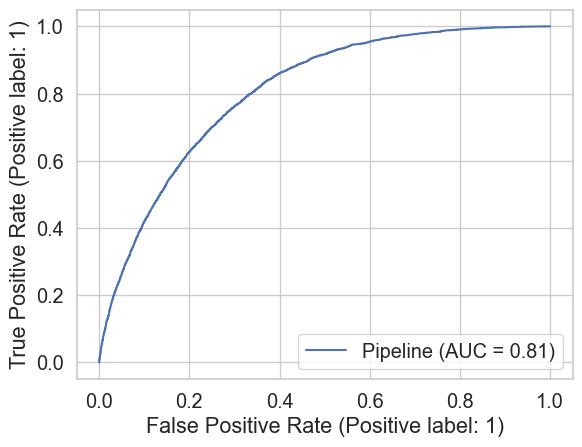

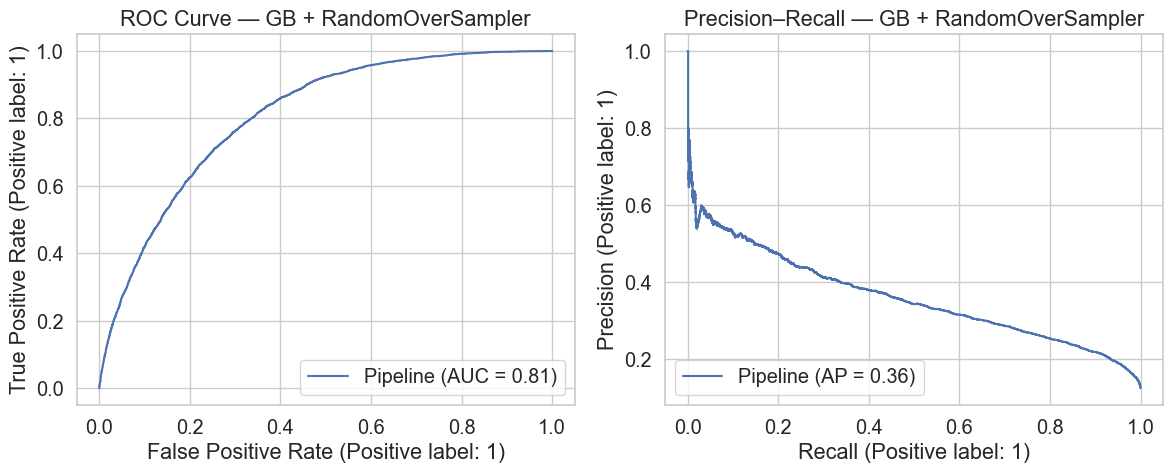

<Figure size 500x400 with 0 Axes>

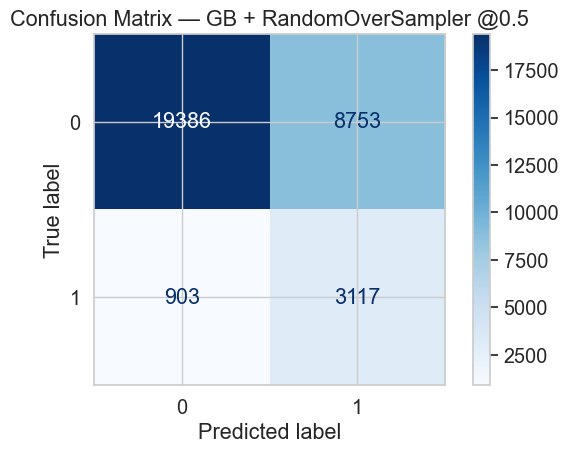

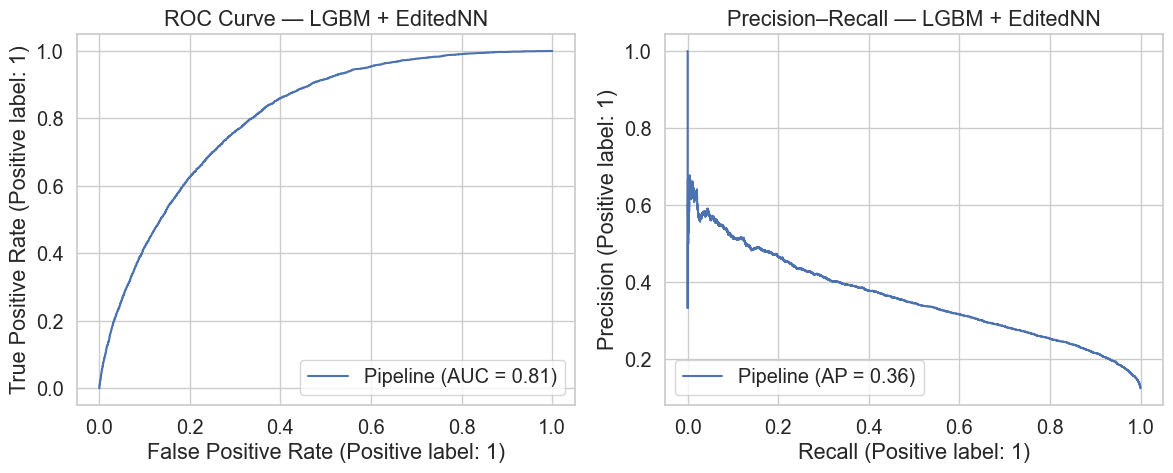

<Figure size 500x400 with 0 Axes>

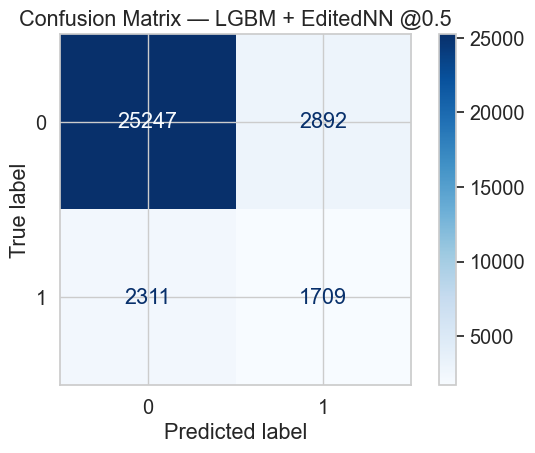

In [57]:
RocCurveDisplay.from_estimator(pipe, X_test, y_test)

for name, pipe in models_eval.items():
    plot_roc_pr(name, pipe, X_test, y_test)
    y_pred, _ = cache[name][0], cache[name][1]
    plot_confusion(name + " @0.5", y_test, y_pred)

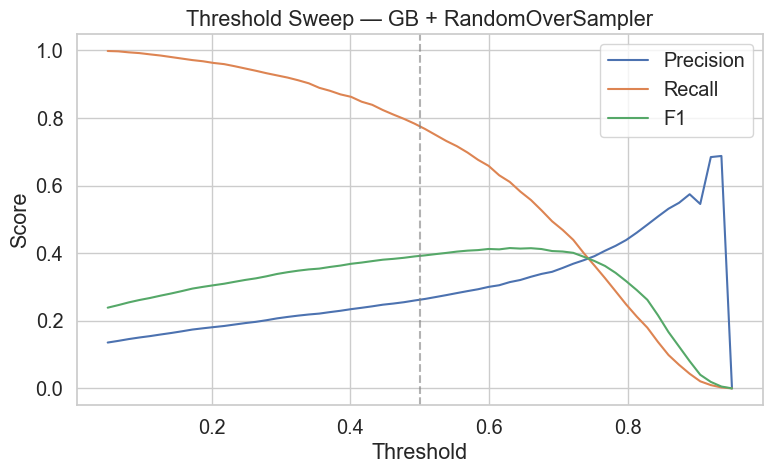

<Figure size 500x400 with 0 Axes>

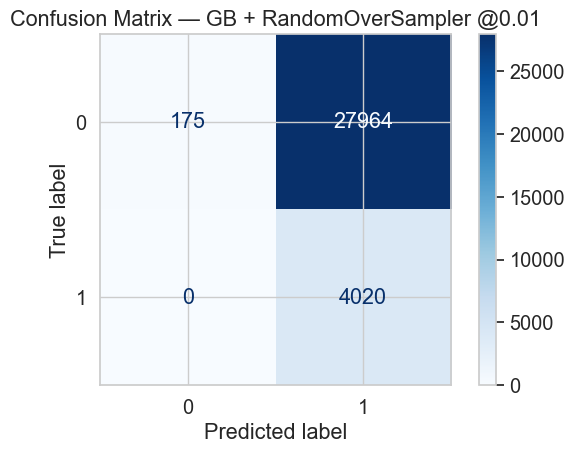

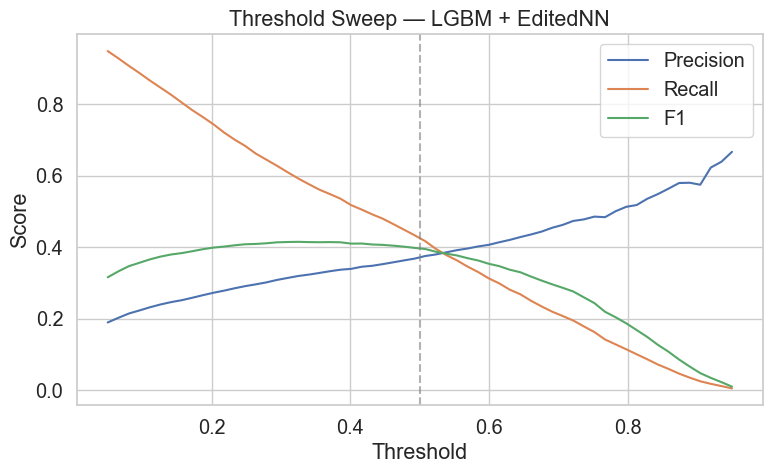

<Figure size 500x400 with 0 Axes>

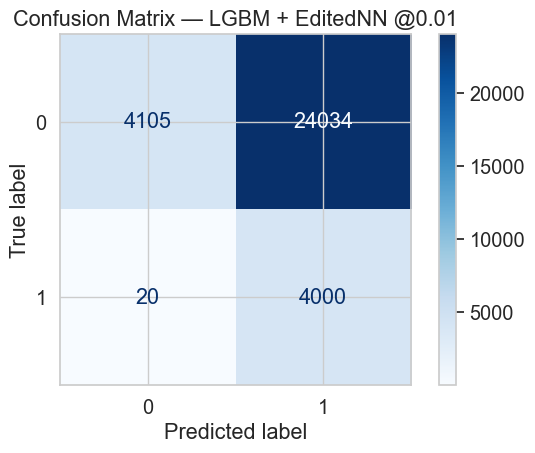

,Model,Threshold,Accuracy,Precision,Recall,F1,AUC
0,GB + RandomOverSampler (tuned@0.01),0.01,0.130,0.126,1.000,0.223,0.808
1,LGBM + EditedNN (tuned@0.01),0.01,0.252,0.143,0.995,0.250,0.806


In [48]:
target_recall = 0.70
rows_tuned = []

for name, pipe in models_eval.items():
    y_pred, y_proba = cache[name]
    # Quét threshold để nhìn trade-off
    plot_threshold_sweep(name, y_test, y_proba, steps=60)

    # Chọn threshold nhỏ nhất đạt recall mục tiêu
    t_star = choose_threshold_for_recall(y_test, y_proba, target_recall=target_recall)

    # Đánh giá lại tại threshold đã chọn
    m_tuned, y_pred_tuned, _ = evaluate_classifier(name + f" (tuned@{t_star:.2f})", pipe, X_test, y_test, threshold=t_star)
    rows_tuned.append(m_tuned)

    # Confusion matrix tại threshold tối ưu theo recall
    plot_confusion(name + f" @{t_star:.2f}", y_test, y_pred_tuned)

tuned_df = pd.DataFrame(rows_tuned).round(3).sort_values("Recall", ascending=False)
display(tuned_df)

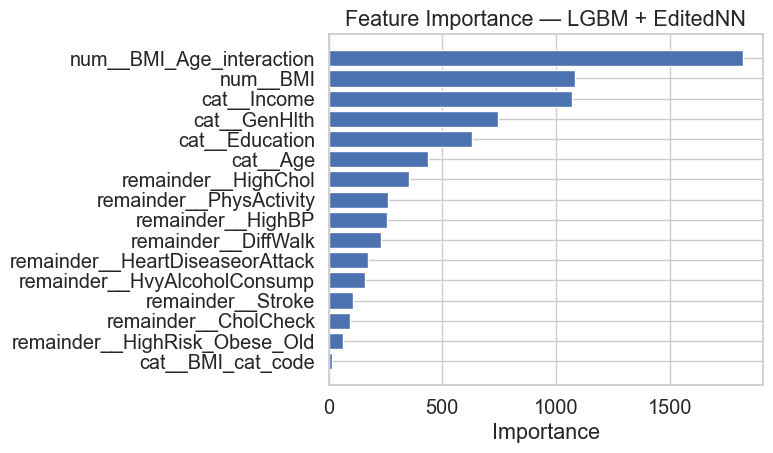

,Feature,Importance
1,num__BMI_Age_interaction,1820
0,num__BMI,1082
4,cat__Income,1069
5,cat__GenHlth,745
3,cat__Education,629
2,cat__Age,437
8,remainder__HighChol,354
12,remainder__PhysActivity,263
7,remainder__HighBP,257
14,remainder__DiffWalk,229


In [58]:
# Lấy pipeline fitted
final_name = "LGBM + EditedNN"  # đổi thành mô hình bạn chọn
final_pipe = models_eval[final_name]

# 1) Lấy tên cột sau preprocessor
#    - get_feature_names_out chỉ có ở một số phiên bản sklearn; nếu lỗi, sẽ fallback tên chung.
try:
    feature_names_pre = final_pipe.named_steps['preprocessor'].get_feature_names_out()
except:
    # Fallback: tạo tên giả nếu version sklearn không hỗ trợ
    feature_names_pre = [f"f_{i}" for i in range(final_pipe.named_steps['preprocessor'].transform(X_train[:1]).shape[1])]

# 2) Lấy mask SelectKBest
mask = final_pipe.named_steps['feature_selection'].get_support(indices=False)

# 3) Tên đặc trưng sau khi select
selected_features = np.array(feature_names_pre)[mask]

# 4) Lấy importance từ LGBM
lgbm_model = final_pipe.named_steps['classifier']
importances = getattr(lgbm_model, "feature_importances_", None)

if importances is not None:
    imp_df = pd.DataFrame({
        "Feature": selected_features,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    # Plot
    plt.figure(figsize=(8, max(4, len(imp_df)*0.3)))
    plt.barh(imp_df["Feature"], imp_df["Importance"])
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance — {final_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    display(imp_df.head(20))
else:
    print("⚠️ Mô hình hiện tại không có thuộc tính feature_importances_.")

In [61]:
import pandas as pd
import numpy as np

# === (1) Hàm tạo đặc trưng giống lúc train ===
def fe_like_training(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # BMI_cat_code theo CDC: Underweight < Normal < Overweight < Obese
    def bmi_to_code(bmi):
        if bmi < 18.5:
            return 0  # Underweight
        elif bmi < 25:
            return 1  # Normal
        elif bmi < 30:
            return 2  # Overweight
        else:
            return 3  # Obese

    df["BMI_cat_code"] = df["BMI"].apply(bmi_to_code).astype(int)

    # BMI x Age (Age là thang 1..13)
    df["BMI_Age_interaction"] = df["BMI"] * df["Age"]

    # HighRisk_Obese_Old: Obese (BMI>=30) & Age >= 10 (~ 65+)
    df["HighRisk_Obese_Old"] = ((df["BMI"] >= 30) & (df["Age"] >= 10)).astype(int)

    return df

# === (2) Hàm dựng DataFrame đầu vào từ dict người dùng + căn chỉnh cột ===
def build_input_df(sample: dict, cols_reference: pd.Index) -> pd.DataFrame:
    """
    sample: dict chứa các trường gốc (ít nhất gồm BMI, Age; khuyến khích đủ các biến nhị phân như trong dữ liệu).
    cols_reference: X_train.columns (cột gốc trước khi vào preprocessor)
    """
    # Tạo DF 1 dòng từ sample
    df_new = pd.DataFrame([sample]).copy()

    # Đảm bảo các cột nhị phân là int (0/1)
    for c in df_new.columns:
        if c != "BMI" and c != "Age" and df_new[c].dtype != float and df_new[c].dtype != int:
            # nếu người dùng đưa '0'/'1' dạng str
            if str(df_new[c].iloc[0]).strip() in {"0","1"}:
                df_new[c] = df_new[c].astype(int)

    # Bổ sung các cột còn thiếu (mặc định 0)
    for c in cols_reference:
        if c not in df_new.columns:
            df_new[c] = 0

    # FE đúng như lúc train
    df_new = fe_like_training(df_new)

    # Chỉ giữ đúng tập cột như lúc train (thứ tự không quá quan trọng cho pandas→ColumnTransformer)
    df_new = df_new[cols_reference.union(["BMI_Age_interaction","HighRisk_Obese_Old","BMI_cat_code"])]
    return df_new

In [62]:
def predict_new(sample_dict: dict, model_key: str = "LGBM + EditedNN", threshold: float = 0.5):
    """
    sample_dict: dict thông tin đầu vào (BMI, Age, các biến 0/1 như HighBP, HighChol, ...)
    model_key: khóa mô hình trong models_eval (ví dụ: "LGBM + EditedNN" hoặc "GB + RandomOverSampler")
    threshold: ngưỡng phân loại (0.5 mặc định, hoặc dùng ngưỡng bạn đã tối ưu ở phần 5)
    """
    pipe = models_eval[model_key]

    # Xây dựng DF đầu vào theo cột gốc X_train (bạn đã có X_train ở bước split)
    df_infer = build_input_df(sample_dict, X_train.columns)

    # Dự đoán
    proba = pipe.predict_proba(df_infer)[:, 1][0]
    pred  = int(proba >= threshold)

    return {
        "model": model_key,
        "threshold": threshold,
        "prob_positive": float(proba),
        "pred_label": int(pred)  # 1 = mắc/tiền tiểu đường, 0 = không
    }

In [63]:
new_person = {
    # Biến liên tục / thứ bậc
    "BMI": 31.2,
    "Age": 11,          # 70–74 (ví dụ quy ước 1: 18–24, ..., 13: 80+)
    "Education": 6,     # tốt nghiệp ĐH
    "Income": 7,        # gần cao nhất
    "GenHlth": 3,       # sức khỏe chung: tốt (1..5)

    # Biến hành vi/sức khỏe nhị phân
    "HighBP": 1,
    "HighChol": 1,
    "CholCheck": 1,
    "Smoker": 0,
    "Stroke": 0,
    "HeartDiseaseorAttack": 0,
    "PhysActivity": 1,
    "Fruits": 1,
    "Veggies": 0,
    "HvyAlcoholConsump": 0,
    "AnyHealthcare": 1,
    "NoDocbcCost": 0,
    "DiffWalk": 0,
    "Sex": 1  # 1: nam, 0: nữ
}

result = predict_new(new_person, model_key="LGBM + EditedNN", threshold=0.5)
result

{'model': 'LGBM + EditedNN',
 'threshold': 0.5,
 'prob_positive': 0.6376860495203016,
 'pred_label': 1}

In [64]:
batch_samples = [
    new_person,  # người 1 như trên
    {
        "BMI": 27.0, "Age": 8, "Education": 5, "Income": 5, "GenHlth": 2,
        "HighBP": 0, "HighChol": 0, "CholCheck": 1, "Smoker": 1, "Stroke": 0,
        "HeartDiseaseorAttack": 0, "PhysActivity": 0, "Fruits": 0, "Veggies": 1,
        "HvyAlcoholConsump": 0, "AnyHealthcare": 1, "NoDocbcCost": 0, "DiffWalk": 0, "Sex": 0
    }
]

df_batch = pd.DataFrame([predict_new(s, "LGBM + EditedNN", threshold=0.5) for s in batch_samples])
df_batch

,model,threshold,prob_positive,pred_label
0,LGBM + EditedNN,0.5,0.637686,1
1,LGBM + EditedNN,0.5,0.038071,0


In [65]:
def predict_new(sample_dict: dict, model_key: str = "LGBM + EditedNN", threshold: float = 0.5):
    """
    Dự đoán nguy cơ mắc tiểu đường trên một bản ghi mới.
    Trả về xác suất % mắc bệnh và không mắc bệnh.
    """
    pipe = models_eval[model_key]
    df_infer = build_input_df(sample_dict, X_train.columns)

    # Lấy xác suất từ mô hình
    probs = pipe.predict_proba(df_infer)[0]
    prob_no = probs[0] * 100      # % không mắc
    prob_yes = probs[1] * 100     # % mắc/tiền tiểu đường
    pred = int(probs[1] >= threshold)

    print(f"🔹 Mô hình: {model_key}")
    print(f"🔹 Ngưỡng phân loại: {threshold:.2f}")
    print(f"➡️  Xác suất KHÔNG mắc tiểu đường: {prob_no:.2f}%")
    print(f"➡️  Xác suất MẮC / TIỀN tiểu đường: {prob_yes:.2f}%")
    print(f"🧩  Kết luận: {'CÓ NGUY CƠ MẮC' if pred==1 else 'KHÔNG MẮC'}")

    return {
        "model": model_key,
        "threshold": threshold,
        "prob_no_diabetes(%)": round(prob_no, 2),
        "prob_yes_diabetes(%)": round(prob_yes, 2),
        "prediction": int(pred)
    }

In [66]:
new_person = {
    "BMI": 31.2,
    "Age": 11,
    "Education": 6,
    "Income": 7,
    "GenHlth": 3,
    "HighBP": 1,
    "HighChol": 1,
    "CholCheck": 1,
    "Smoker": 0,
    "Stroke": 0,
    "HeartDiseaseorAttack": 0,
    "PhysActivity": 1,
    "Fruits": 1,
    "Veggies": 0,
    "HvyAlcoholConsump": 0,
    "AnyHealthcare": 1,
    "NoDocbcCost": 0,
    "DiffWalk": 0,
    "Sex": 1
}

result = predict_new(new_person, model_key="LGBM + EditedNN", threshold=0.5)
result

🔹 Mô hình: LGBM + EditedNN
🔹 Ngưỡng phân loại: 0.50
➡️  Xác suất KHÔNG mắc tiểu đường: 36.23%
➡️  Xác suất MẮC / TIỀN tiểu đường: 63.77%
🧩  Kết luận: CÓ NGUY CƠ MẮC


{'model': 'LGBM + EditedNN',
 'threshold': 0.5,
 'prob_no_diabetes(%)': 36.23,
 'prob_yes_diabetes(%)': 63.77,
 'prediction': 1}